In [1]:
import numpy as np
from scipy.special import rel_entr

import matplotlib.pyplot as plt
import seaborn as sns

import keras
import tensorflow as tf
import pandas as pd
from sklearn.metrics import pairwise_distances

from collections import defaultdict

sns.set_context('talk')
%config InlineBackend.figure_format='retina'


# Experiment setup 
1. We have multiple _ground truth_ distributions from which we only ever observe discrete, binary outputs. Given the ground truth distribution we can compute a "distance" or "loss" between it and some other distribution (e.g. a predicted distribution)
2. We can sample from these ground truth distributions. Given a sample (a specific, binary output) we can also compute a "distance" or "loss" between the sample (a very simple distribution) and the ground truth distribution
3. We have different loss functions


In [2]:
color1 = '#6138ba'
color2 = 'pink'

In [3]:
BINS = np.arange(1, 12)

In [4]:
class Distribution:

    def __init__(self, prob_dict: dict, eps=0.001):
        self.bins = BINS
        self.num_bins = len(self.bins)
        self.prob_dict = prob_dict
        self.eps = eps
        self.probs = self.prob_dict_to_array(self.prob_dict)

    def prob_dict_to_array(self, prob_dict):

        # Assert values are valid probability distribution
        assert np.isclose(sum(list(prob_dict.values())), 1, atol=0.0001)

        probs = np.zeros(self.num_bins)
        for bin_, p in prob_dict.items():
            probs[bin_ - 1] = p

        # Assert probs is valid distribution

        assert np.isclose(probs.sum(), 1, atol=0.0001)

        # Add a tiny amount of noise to replicate "label smoothing"
        if self.eps != 0:
            bins_with_zero_prob_mass = (probs == 0).sum()
            bins_with_nonzero_prob_mass = (probs != 0).sum()
            eps_remove_from_bins = self.eps / bins_with_nonzero_prob_mass
            eps_add_to_bins = self.eps / bins_with_zero_prob_mass
            probs = np.where(
                probs==0, 
                eps_add_to_bins, 
                probs - eps_remove_from_bins
            )

            # Assert probs is valid distribution
            assert np.isclose(probs.sum(), 1, atol=0.0001)

        return probs


    def sample(self, n_samples):
        # Sample the count of times each bin occurs
        return np.random.multinomial(n=n_samples, pvals=self.probs)


    def sample_ohe(self, n_samples):
        # Sample the count of times each bin occurs
        counts = self.sample(n_samples)

        # One hot encode
        l = []
        for i, x in enumerate(counts):
            l.extend([i] * x)
        one_hot_encoded_samples = keras.utils.to_categorical(l, num_classes=11)
        return one_hot_encoded_samples

    @classmethod
    def normalize_samples(cls, samples):
        return samples / samples.sum()

    @classmethod
    def normalize_one_hot_samples(cls, ohe_samples):
        ohe_samples_summed = ohe_samples.sum(axis=0)
        return ohe_samples_summed / ohe_samples_summed.sum()


def plot_distribution(p):
    x = np.arange(1, len(p) + 1)
    plt.bar(x=x, height=p, alpha=0.5, label='p', color=color1, edgecolor='black')
    plt.xticks(x)
    plt.xlabel('bin')
    plt.ylabel('Probability')
    plt.ylim(top=1.1)

In [5]:
def plot_distributions(distributions_list):

    # Currently only able to handle 4
    num_plots = len(distributions_list)
    assert num_plots <= 4

    fig, axs = plt.subplots(nrows=1, ncols=num_plots, figsize=(25, 4))

    for i, distribution_dict in enumerate(distributions_list):

        for name, distribution in distribution_dict.items():
            x = np.arange(1, len(distribution.probs) + 1)
            axs[i].bar(x=x, height=distribution.probs, alpha=0.5, label=name, color=EXPERIMENT_PARAMS['color'][name], edgecolor='black')

        axs[i].set_xticks(x)
        axs[i].set_ylim(top=1.1)
        axs[i].set_xlabel('Bin')
        axs[i].legend(fontsize=12)

        if i == 0:
            axs[i].set_ylabel('Probability')

        axs[i].set_title(f'#{i + 1}')

    plt.show()


In [6]:
EXPERIMENT_PARAMS = {
    'eps': 0.001,
    'n_samples': 100_000,
    'color': {'p': '#6138ba', 'q': 'pink'}
}

ground_truth_distributions = [
    {'p': Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])},
    {'p': Distribution({1: 0.9, 11: 0.1}, eps=EXPERIMENT_PARAMS['eps'])},
    {'p': Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
    {'p': Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)},
]

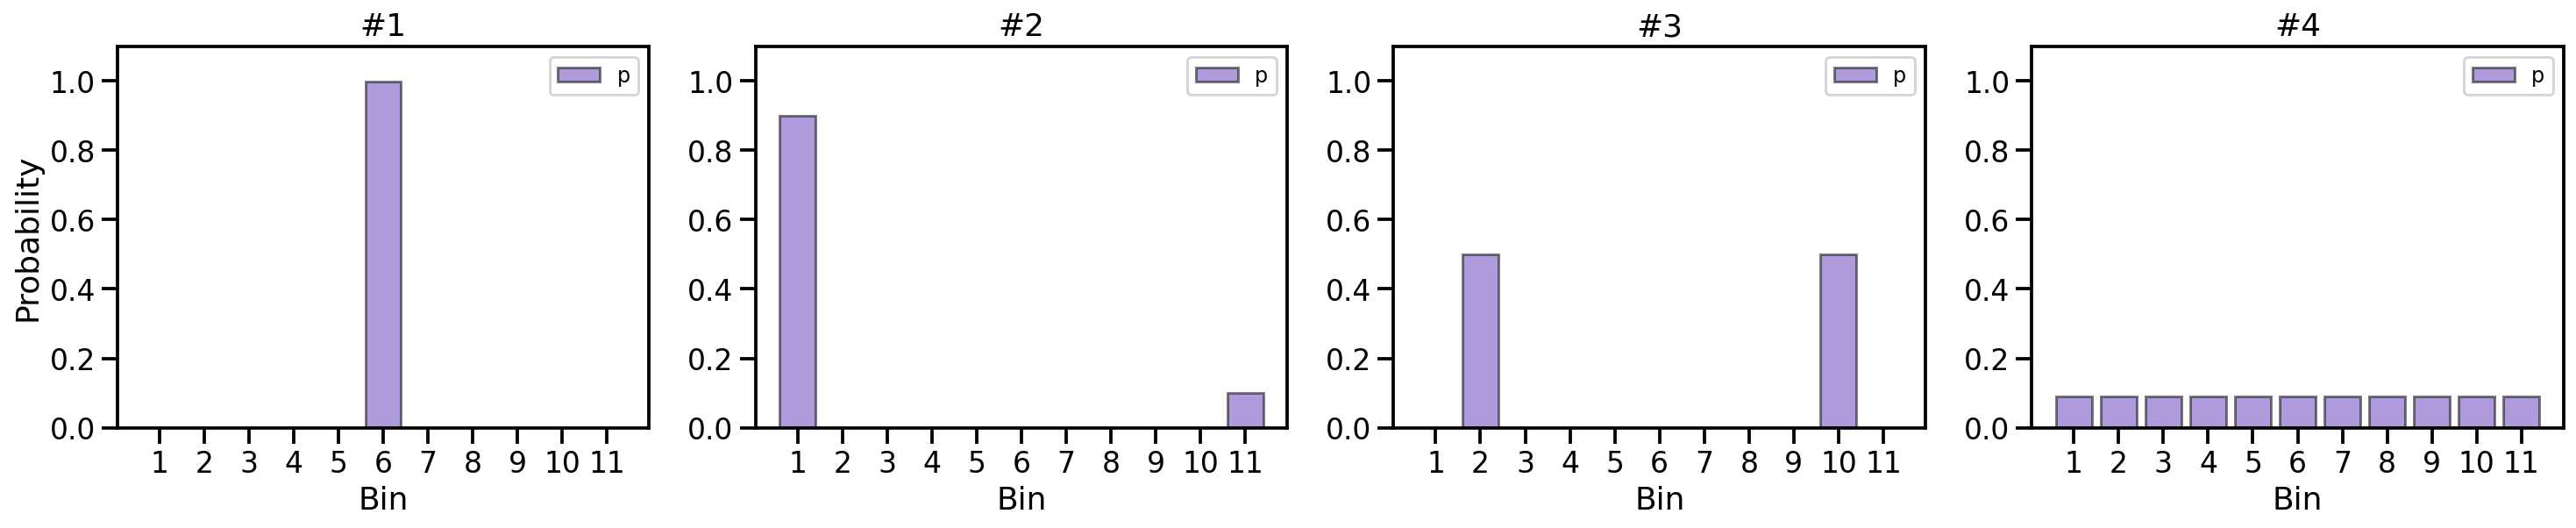

In [7]:
plot_distributions(ground_truth_distributions)

In [8]:
# Sample from ground truth distributions
empirical_distributions = [
    x['p'].sample(EXPERIMENT_PARAMS['n_samples']) / EXPERIMENT_PARAMS['n_samples'] 
    for x in ground_truth_distributions
]

# Construct correct format of empirical distribution
empirical_distributions = [
    {
        'q': Distribution(
            {
                i: prob for i, prob in zip(np.arange(1, 12), empirical_distribution)
            }, 
            eps=0 # No noise needed, already taken into account when constructing ground truth distributions
        )
    }
    for empirical_distribution, ground_truth_distribution in zip(empirical_distributions, ground_truth_distributions)
]

# Construct combined ground truth and empirical distributions
gt_and_empirical_distributions = []

for gtd, ed in zip(ground_truth_distributions, empirical_distributions):
    combined_dict = {}

    # Ground truth
    gtd_name = list(gtd.keys())[0]
    combined_dict[gtd_name] = gtd[gtd_name]

    # Empirical
    ed_name = list(ed.keys())[0]
    combined_dict[ed_name] = ed[ed_name]

    gt_and_empirical_distributions.append(combined_dict)

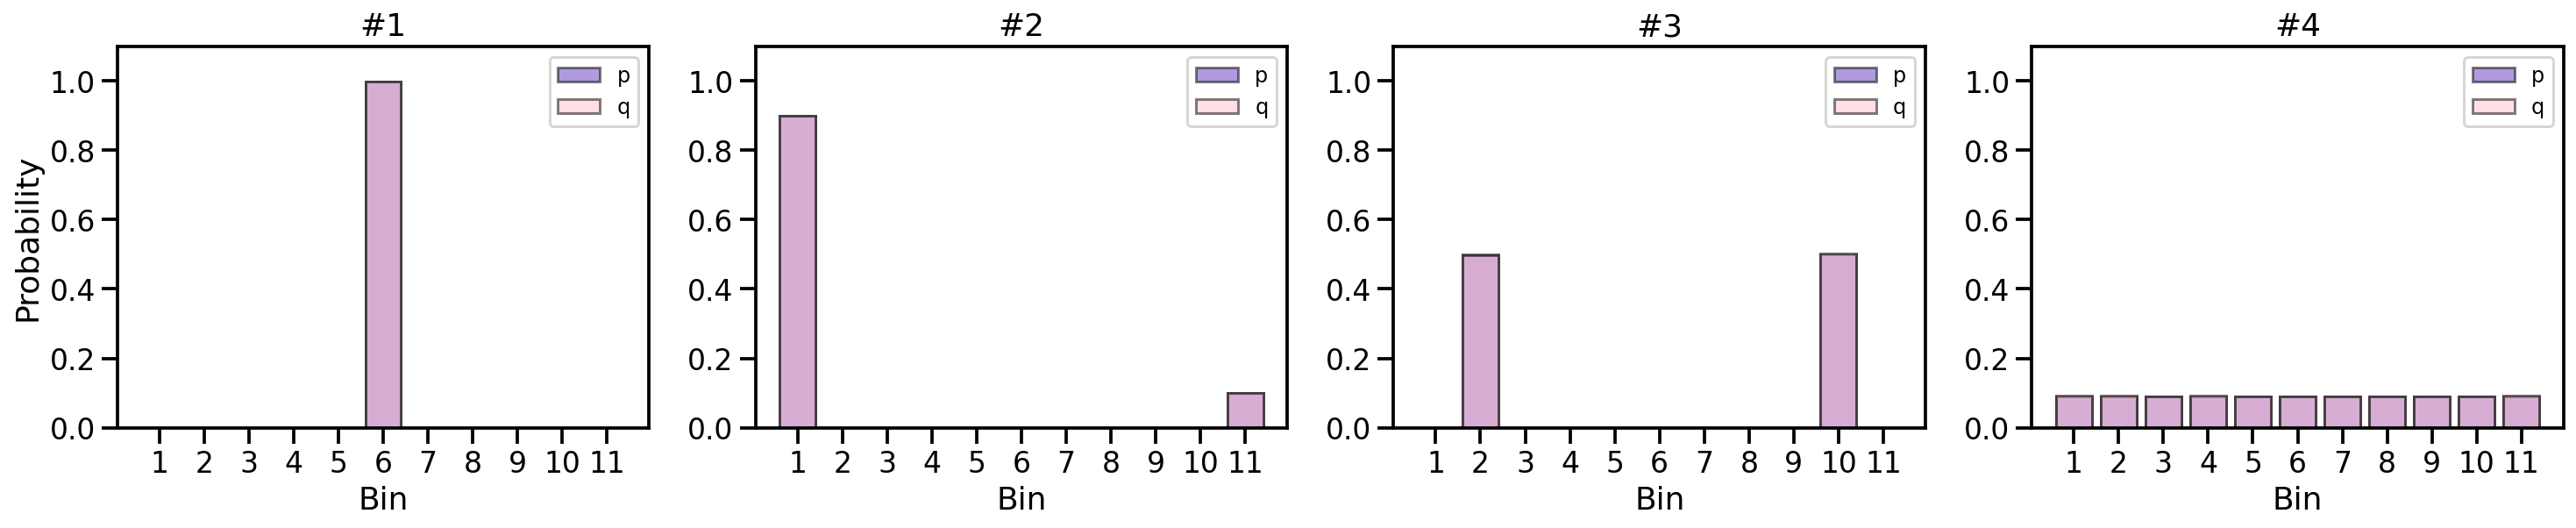

In [9]:
plot_distributions(gt_and_empirical_distributions)

In [10]:
d = ground_truth_distributions[0]['p']

In [11]:
samp = d.sample(n_samples=1000)
samp

array([  0,   0,   0,   0,   0, 999,   0,   0,   1,   0,   0])

In [12]:
Distribution.normalize_samples(samp)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   , 0.001,
       0.   , 0.   ])

In [13]:
samp_ohe = d.sample_ohe(n_samples=1000)
samp_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [14]:
Distribution.normalize_one_hot_samples(samp_ohe)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.999, 0.   , 0.   , 0.001,
       0.   , 0.   ], dtype=float32)

##  Investigation 1: What loss function most effectively handles the "two towers" ground truth distribution

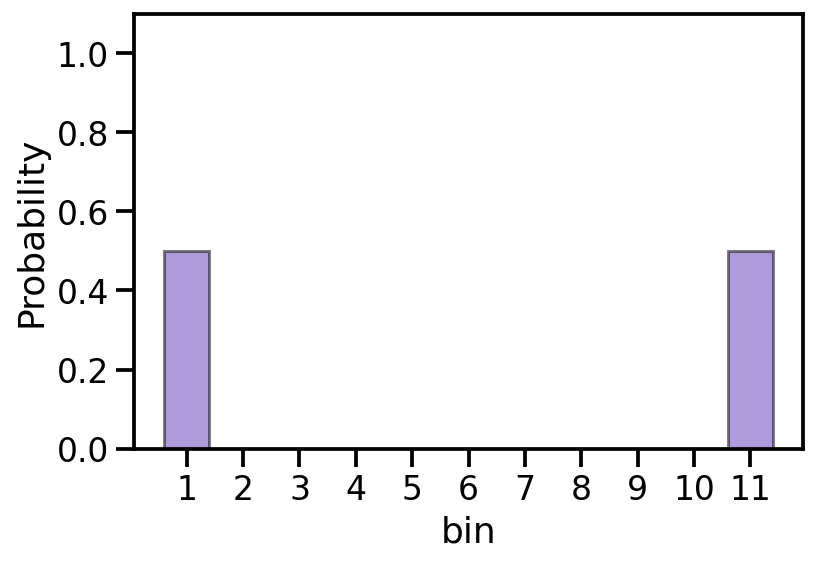

In [15]:
d = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])

plot_distribution(d.probs)

In [16]:
import pandas as pd

In [35]:
MAX_WL_DISTANCE = 2 # Based on the kernel similarity idea we are using
MAX_CE_DISTANCE = 10

def cross_entropy(p, q, normalize=False):
    ce = -np.sum(p * np.log(q))
    if normalize:
        return ce / MAX_CE_DISTANCE
    return ce


def create_D(bins):
    """Create distance matrix between bins"""

	# Currently using index instead of middle of bin. Investigate.
    bin_mid = [i for i, x in enumerate(bins)]

    bin_mid_array = np.array(bin_mid)
    D = pd.DataFrame(
	    pairwise_distances(bin_mid_array.reshape(-1, 1))
    )
    D = D.values

    return D


D = create_D(BINS)


def ws_loss(y_true, y_pred, D, normalize=False):
    """Working implementation of WS loss"""
    p = y_true
    q = y_pred

    idx_of_true_class = np.where(p == 1)[0][0]

    distance_of_classes_to_true_class = D[idx_of_true_class, :]
    wl = sum(q * distance_of_classes_to_true_class)

    if normalize:
        return wl / MAX_WL_DISTANCE
    return wl


def linear_combination_loss(p, q, alpha=0.5, beta=0.5, normalize=False):
    # wl = ws_loss(p, q, D)

    wl = rps(p, q)
    ce = cross_entropy(p, q)


    
    if normalize:
        ce /= MAX_CE_DISTANCE
        wl /= MAX_WL_DISTANCE

    return alpha * ce + beta * wl 


def plot_losses(loss_dict, title=None):

    # Get losses in correct format
    loss_dict_by_name = defaultdict(list)
    for name, ld in loss_dict.items():
        loss_names = list(ld.keys())
        for loss_name in loss_names:
            loss_dict_by_name[loss_name].append(ld[loss_name])

    plt.figure(figsize=(8, 5))
    barWidth = 0.25
    br = np.arange(1, 5)
    for loss_name, loss_list in loss_dict_by_name.items():
        plt.bar(br, loss_list, width = barWidth, edgecolor ='grey', label =loss_name)
        br = [x + barWidth for x in br]

    plt.legend(fontsize=12)
    plt.xticks(np.arange(1, 5))
    plt.xlabel('Bin')
    plt.ylabel('Loss')
    if title is not None:
        plt.title(title)
    else:
        plt.title("Different Loss's by Bin")
    plt.show()

    # return loss_dict_by_name


def to_cdf(x):
    return np.cumsum(x, axis=-1)


# def rps(targets, probs):
#     targets = to_cdf(targets)
#     probs = to_cdf(probs)
#     n_bins = probs.shape[-1]
#     return np.mean((probs - targets)**2, axis=-1) # / n_bins


def rps(targets, probs):
    targets = to_cdf(targets)
    probs = to_cdf(probs)
    # Interesting to try rps raised to the 4th...
    return np.mean((probs - targets)**4, axis=-1) 

In [31]:
def experiment_1(D, alpha=0.5, beta=0.5, normalize=False):
    ground_truth_distributions = [
        {'p': Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
        {'p': Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
        {'p': Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
        {'p': Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
    ]

    predicted_distributions = [
        {'q': ground_truth_distributions[0]['p']}, # The actual, true data generating distribution
        {'q': Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])},
        {'q': Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])},
        {'q': Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)},
    ]

    gt_and_predicted_distributions = []
    for gtd, pred_d in zip(ground_truth_distributions, predicted_distributions):
        combined_dict = {}

        # Ground truth
        gtd_name = list(gtd.keys())[0]
        combined_dict[gtd_name] = gtd[gtd_name]

        # Predicted
        pd_name = list(ed.keys())[0]
        combined_dict[pd_name] = pred_d[pd_name]

        gt_and_predicted_distributions.append(combined_dict)


    full_loss_dict = {}
    for i, distribution_dict in enumerate(gt_and_predicted_distributions):
        
        ground_truth_distribution = distribution_dict['p']
        predicted_distribution = distribution_dict['q']
        
        # Generate samples from the ground truth distribution. These samples are effectively what we would "see" during the learning process
        ohe_samples = ground_truth_distribution.sample_ohe(EXPERIMENT_PARAMS['n_samples'])

        # Given the sample (the data points we would see during training), compute the avg loss for each loss function
        mean_ce = np.array([cross_entropy(ohe_sample, predicted_distribution.probs, normalize=normalize) for ohe_sample in ohe_samples]).mean()
        mean_rps = np.array([rps(ohe_sample, predicted_distribution.probs) for ohe_sample in ohe_samples]).mean()
        mean_ws = np.array([ws_loss(ohe_sample, predicted_distribution.probs, D, normalize=normalize) for ohe_sample in ohe_samples]).mean()
        mean_comb = np.array([linear_combination_loss(ohe_sample, predicted_distribution.probs, alpha=alpha, beta=beta, normalize=normalize) for ohe_sample in ohe_samples]).mean()

        loss_dict = {'mean_ce': mean_ce, 'mean_rps': mean_rps,'mean_ws': mean_ws, 'mean_comb': mean_comb}
        # loss_dict = {'mean_rps': mean_rps}
        full_loss_dict[i] = loss_dict

    return gt_and_predicted_distributions, full_loss_dict

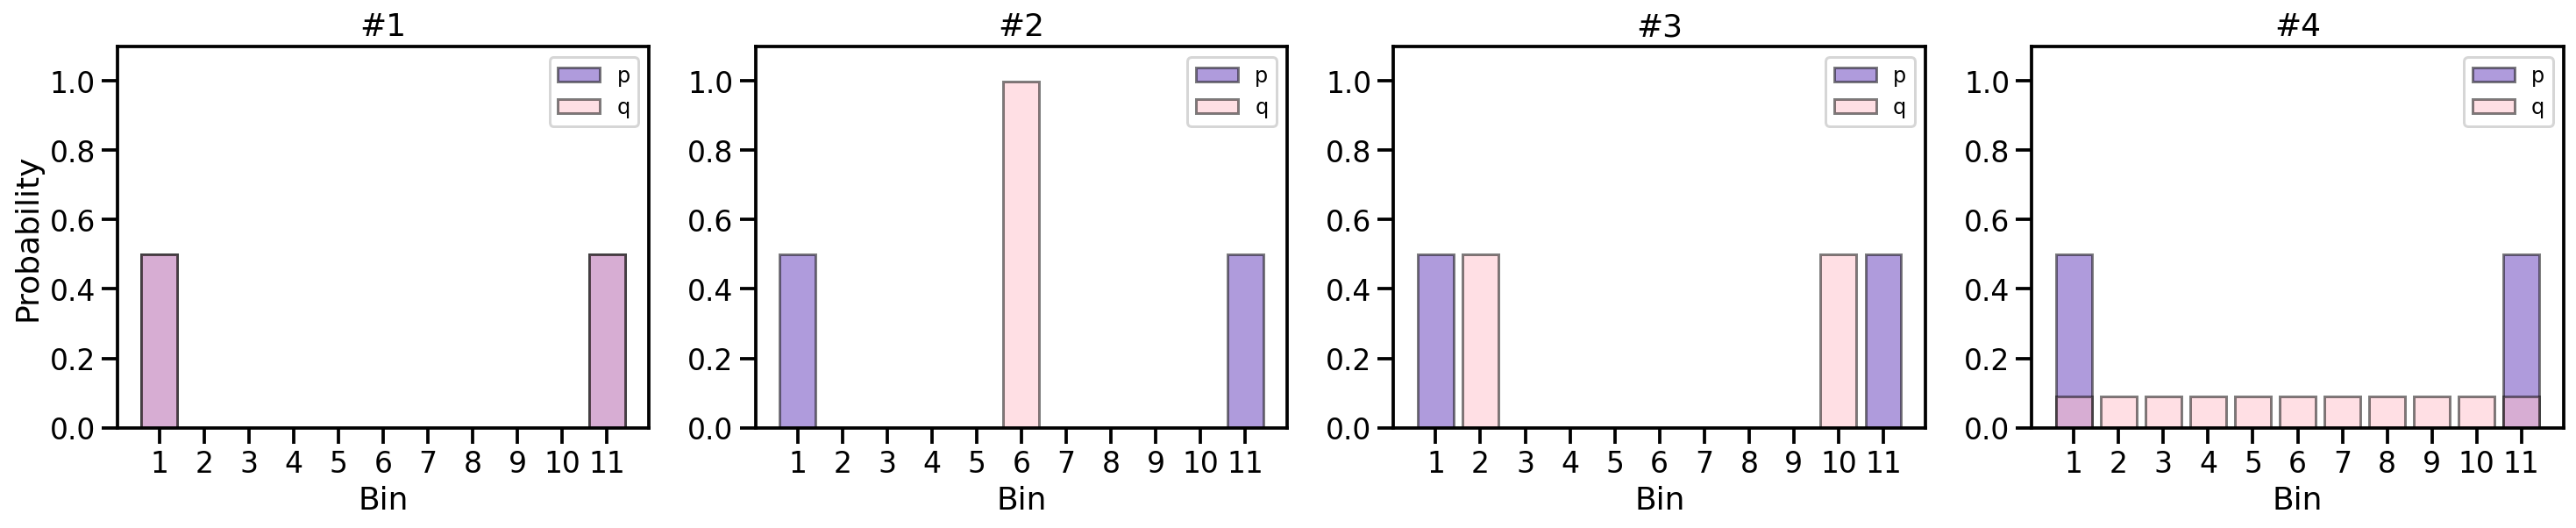

In [28]:
D = create_D(BINS)
gt_and_predicted_distributions, full_loss_dict = experiment_1(D)
plot_distributions(gt_and_predicted_distributions)

#### Exp 1.1: `Baseline D, alpha=0.5, beta=0.5`

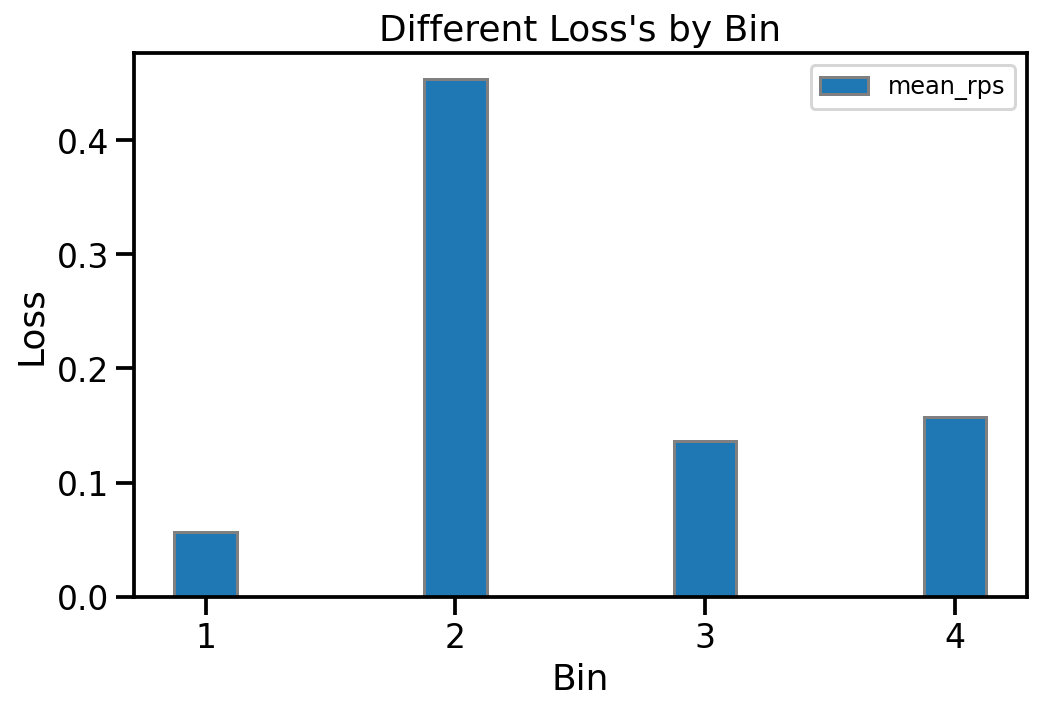

In [36]:
D = create_D(BINS)
gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=0.1, beta=0.9)
plot_losses(full_loss_dict)

#### Exp 1.2: `D = expit(D - 5), alpha=0.5, beta=0.5`

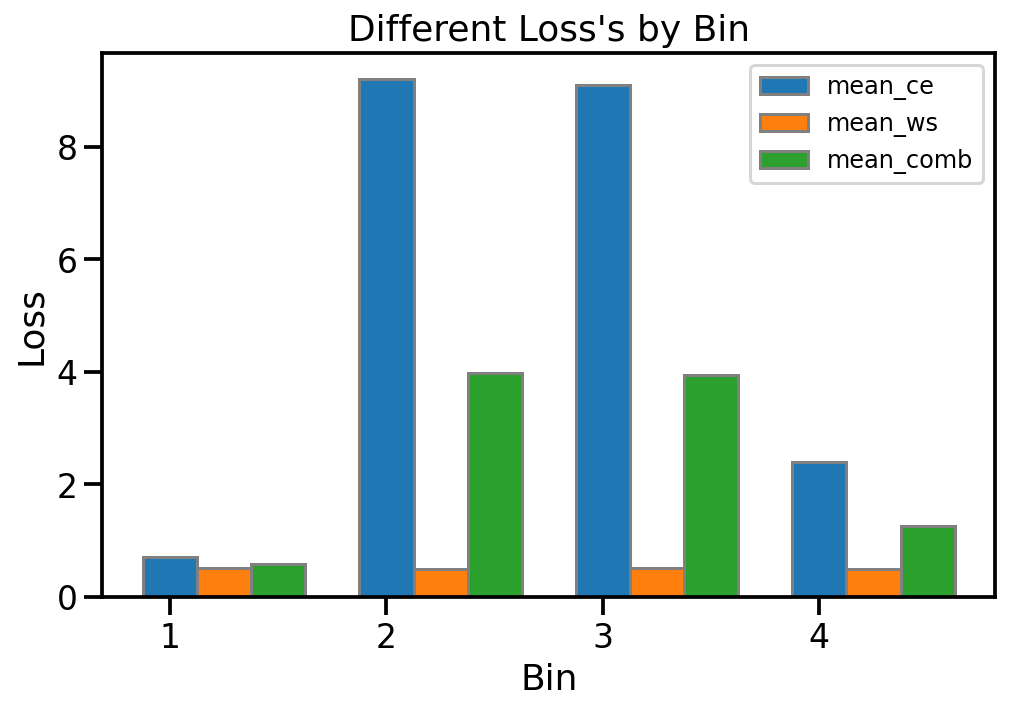

In [606]:
D = create_D(BINS)
D = expit(D - 5)
gt_and_predicted_distributions, full_loss_dict = experiment_1(D)
plot_losses(full_loss_dict)

#### Exp 1.3: `D = expit(D - 2), alpha=0.5, beta=0.5`

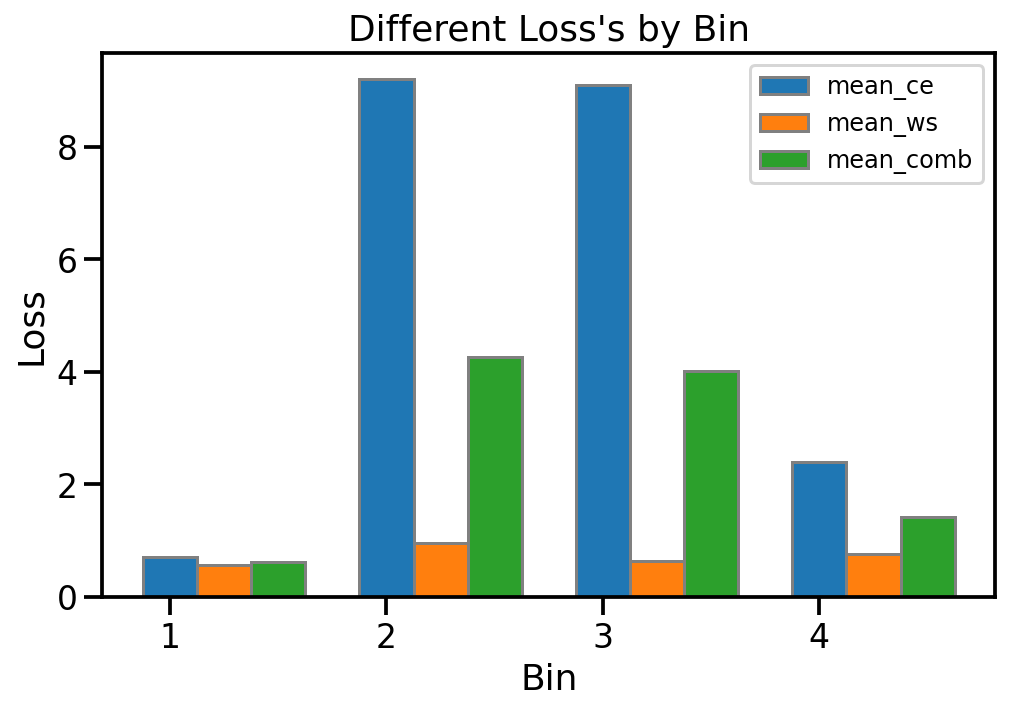

In [607]:
D = create_D(BINS)
D = expit(D - 2)
gt_and_predicted_distributions, full_loss_dict = experiment_1(D)
plot_losses(full_loss_dict)

#### Exp 1.4: `D = expit(D - 2) * 10, alpha=0.5, beta=0.5`

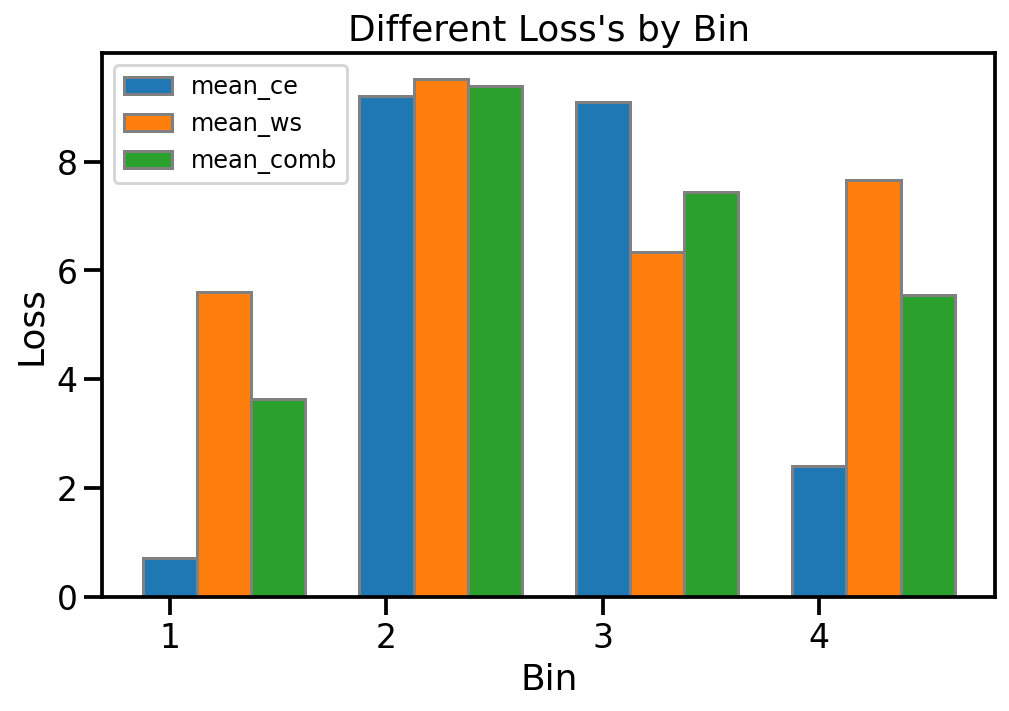

In [608]:
D = create_D(BINS)
D = expit(D - 2) * 10
gt_and_predicted_distributions, full_loss_dict = experiment_1(D)
plot_losses(full_loss_dict)

#### Exp 1.5: `D = expit(D - 2) * 10, alpha=0.3, beta=0.7`

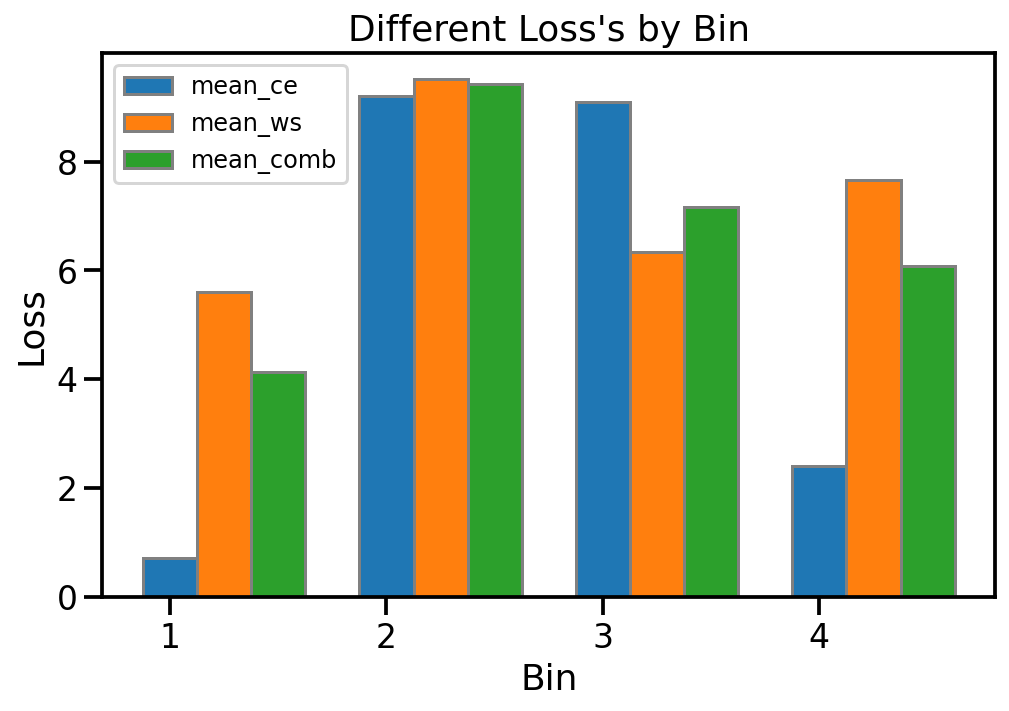

In [620]:
D = create_D(BINS)
D = expit(D - 2) * 10
gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=0.3, beta=0.7)
plot_losses(full_loss_dict)

#### Exp 1.6: `D = expit(D - 2) * 10, alpha=0.1, beta=0.9`
This is the first time we have managed to get the loss bin 3 to be the second lowest! Yay! The only problem is, bin 1 is no long the lowest by far, which would have been preferable.

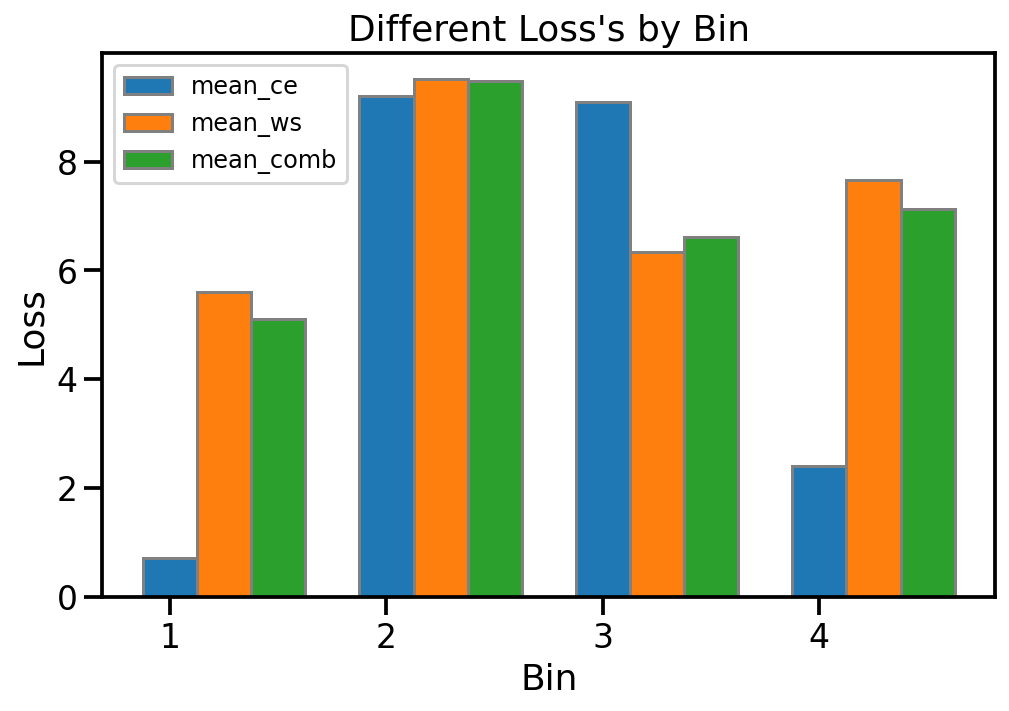

In [621]:
D = create_D(BINS)
D = expit(D - 2) * 10
gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=0.1, beta=0.9)
plot_losses(full_loss_dict)

#### Exp 2.1: `D = Kernel(0, D, std=2), alpha=0.5, beta=0.5`

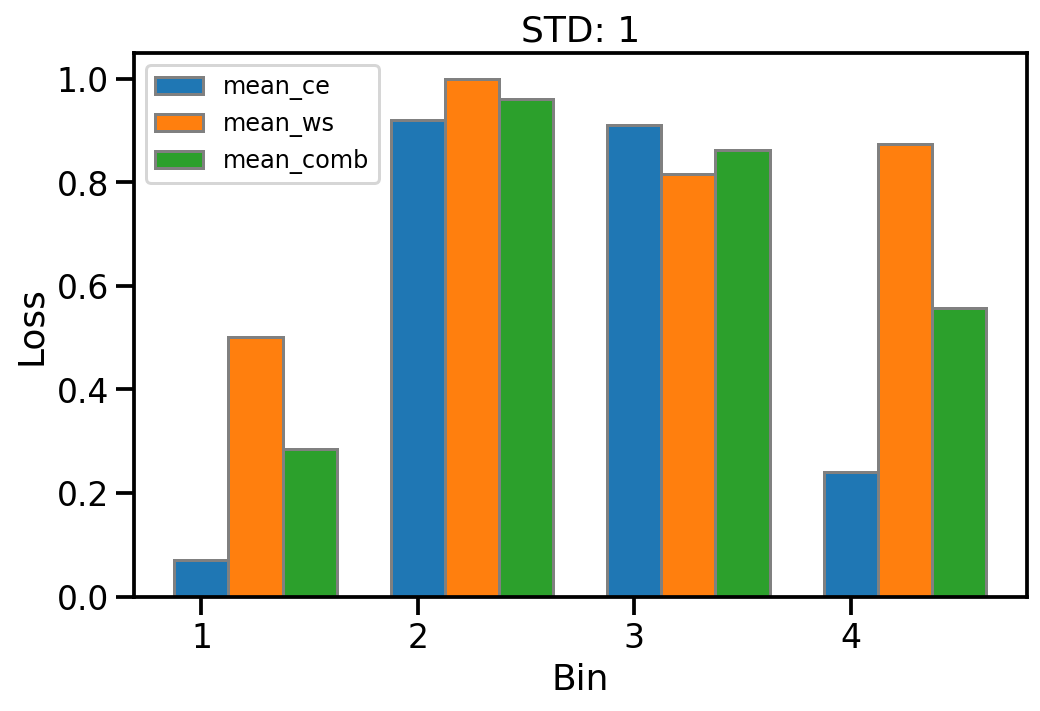

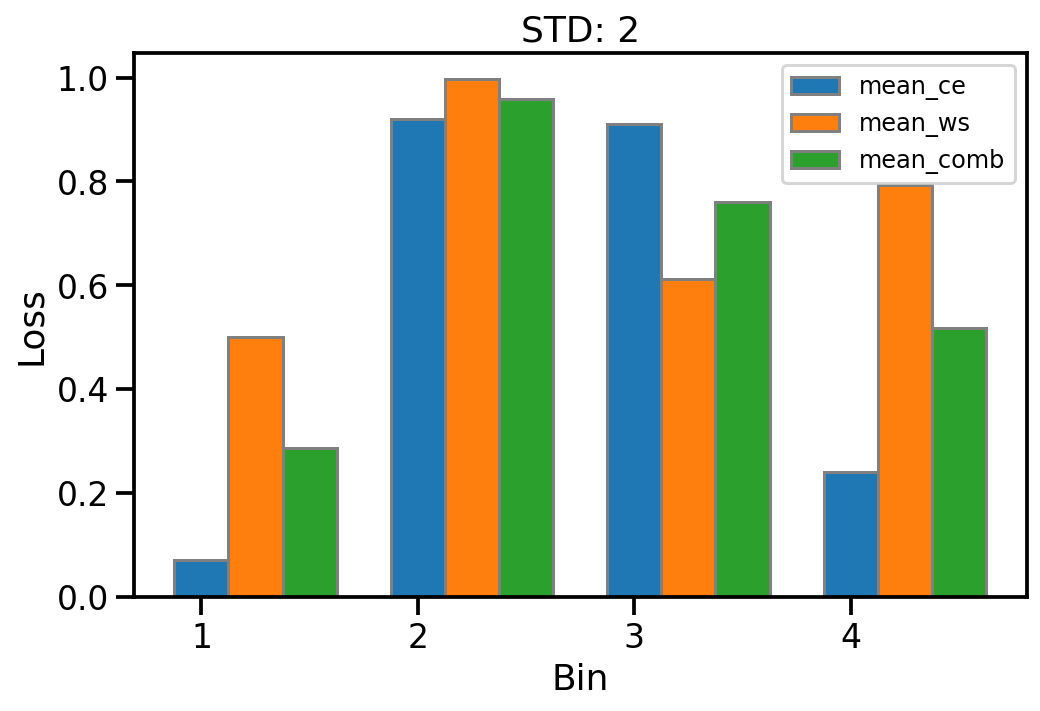

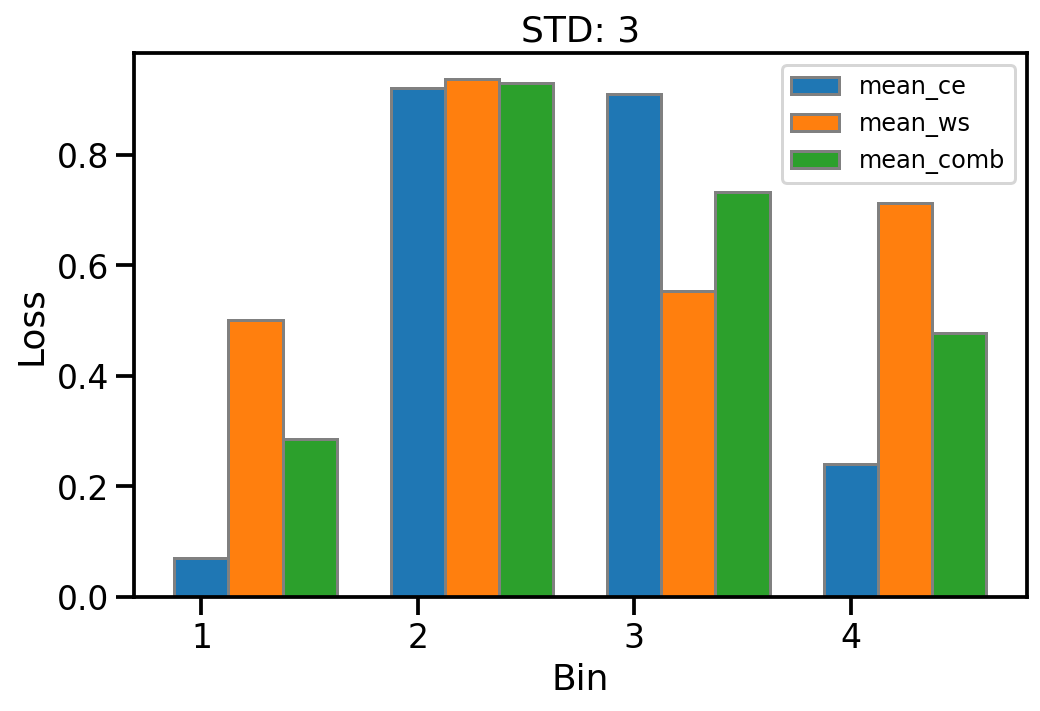

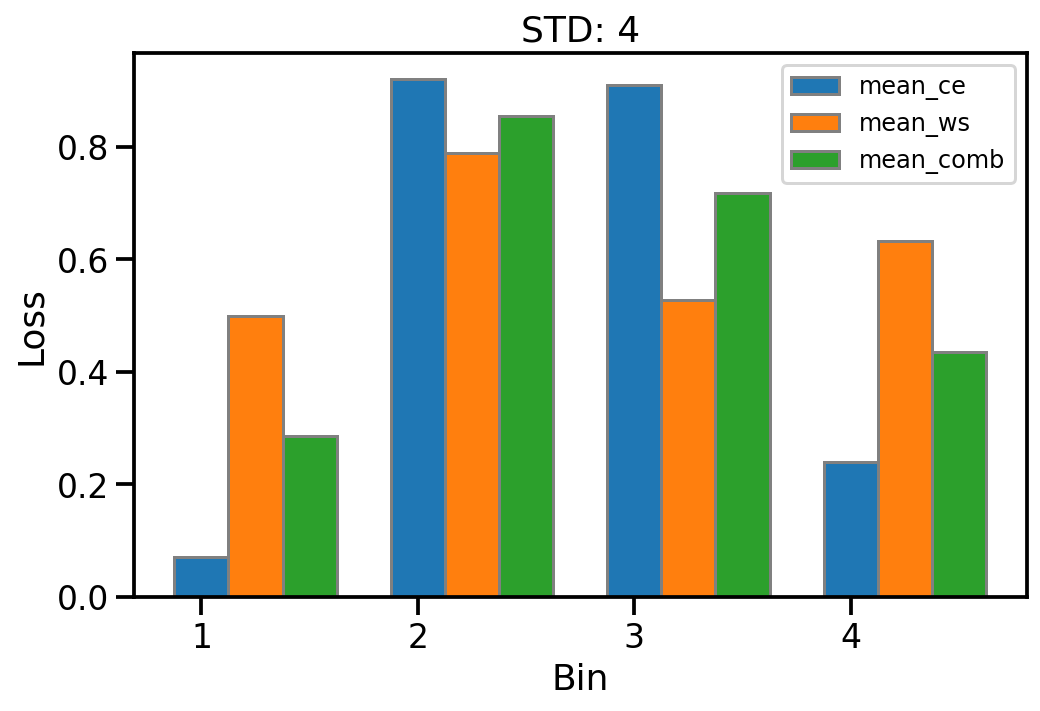

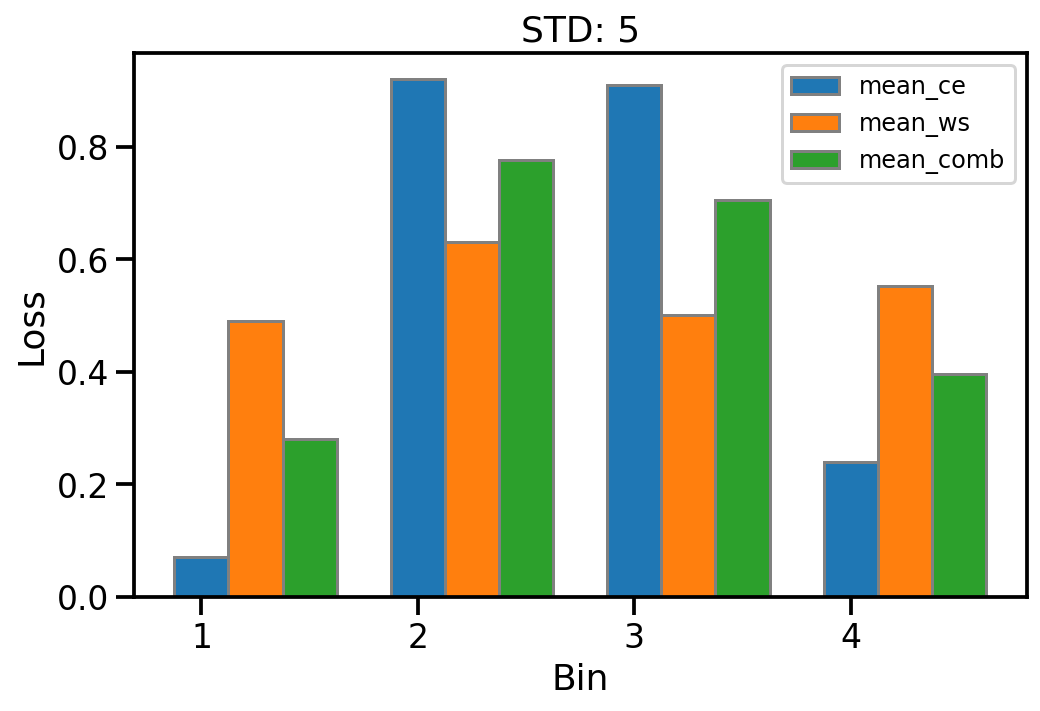

In [637]:
for std in [1, 2, 3, 4, 5]:
    D = create_D(BINS)
    D = kernel_distance(0, D, std=std)
    gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=0.5, beta=0.5, normalize=True)
    plot_losses(full_loss_dict, title=f'STD: {std}')

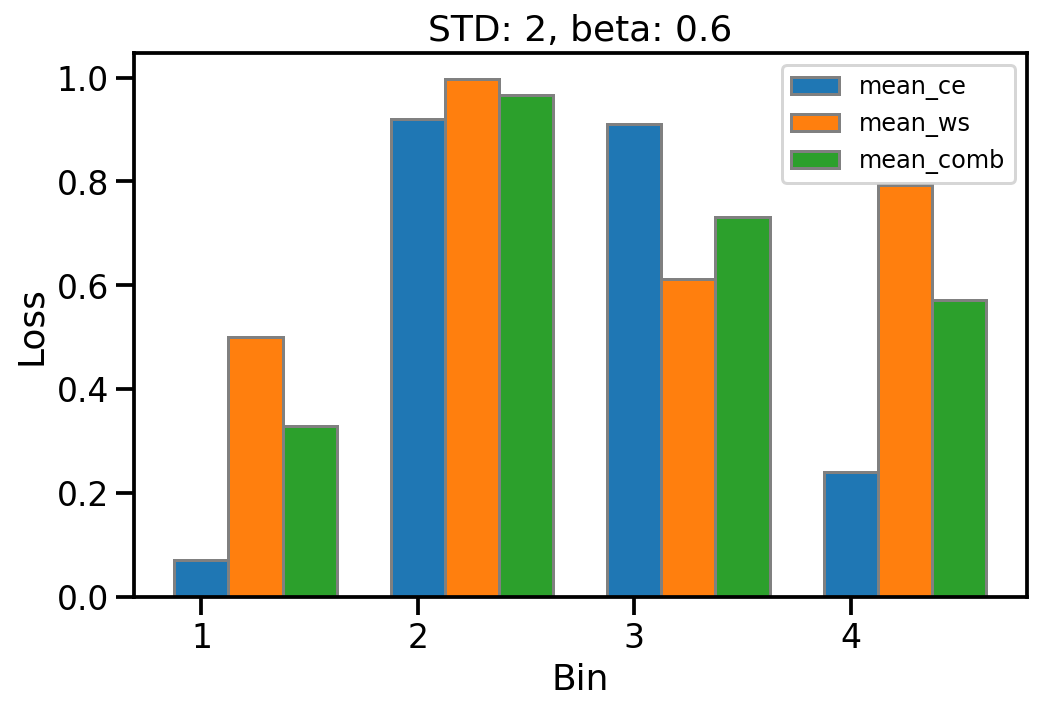

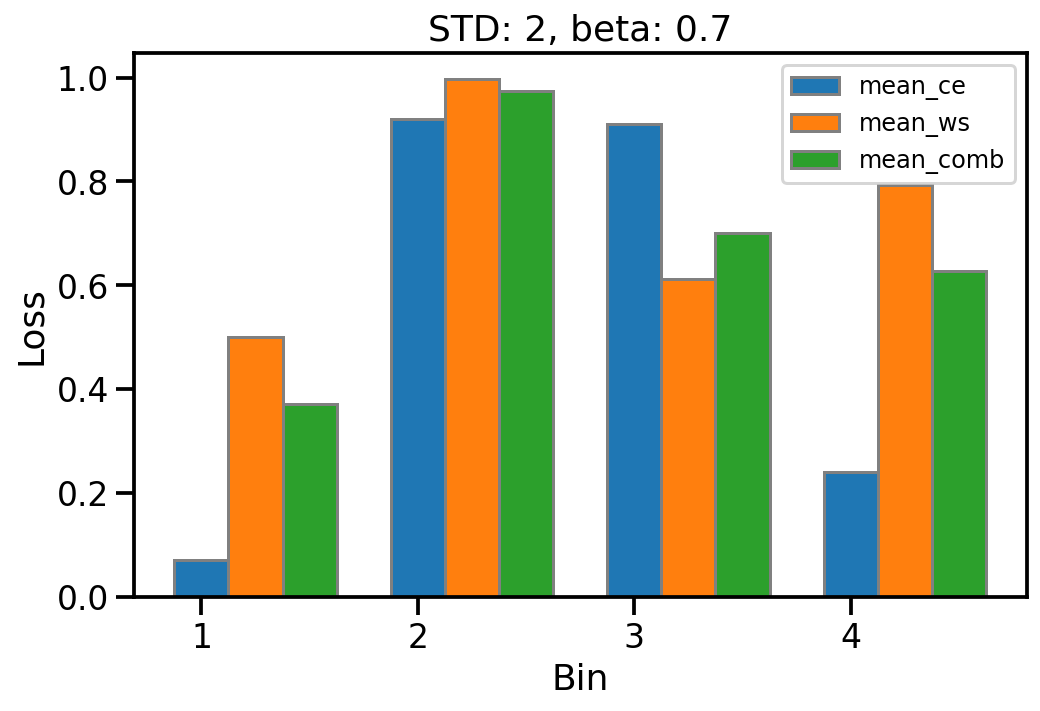

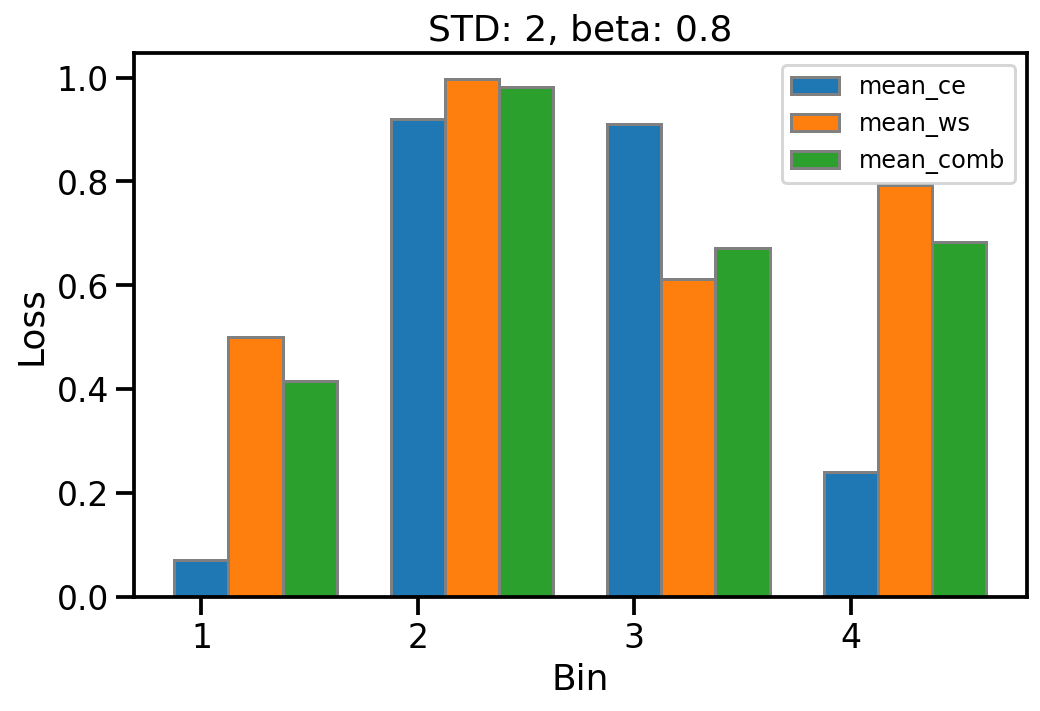

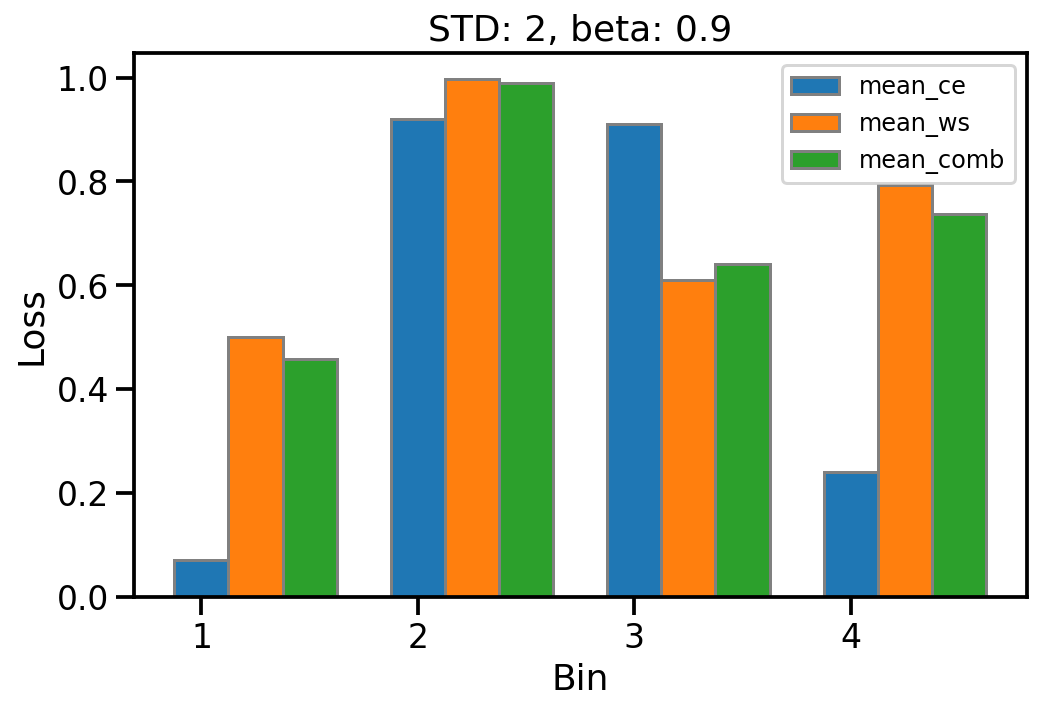

In [638]:
for beta in [0.6, 0.7, 0.8, 0.9]:
    alpha = 1 - beta
    D = create_D(BINS)
    D = kernel_distance(0, D, std=2)
    gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=alpha, beta=beta, normalize=True)
    plot_losses(full_loss_dict, title=f'STD: 2, beta: {beta}')

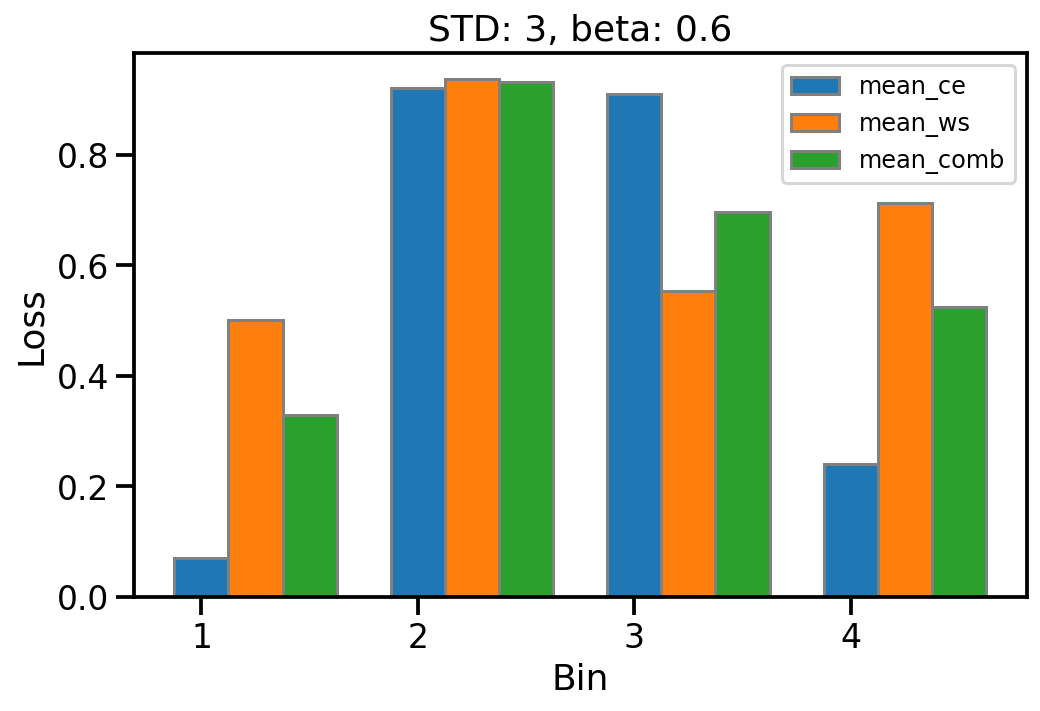

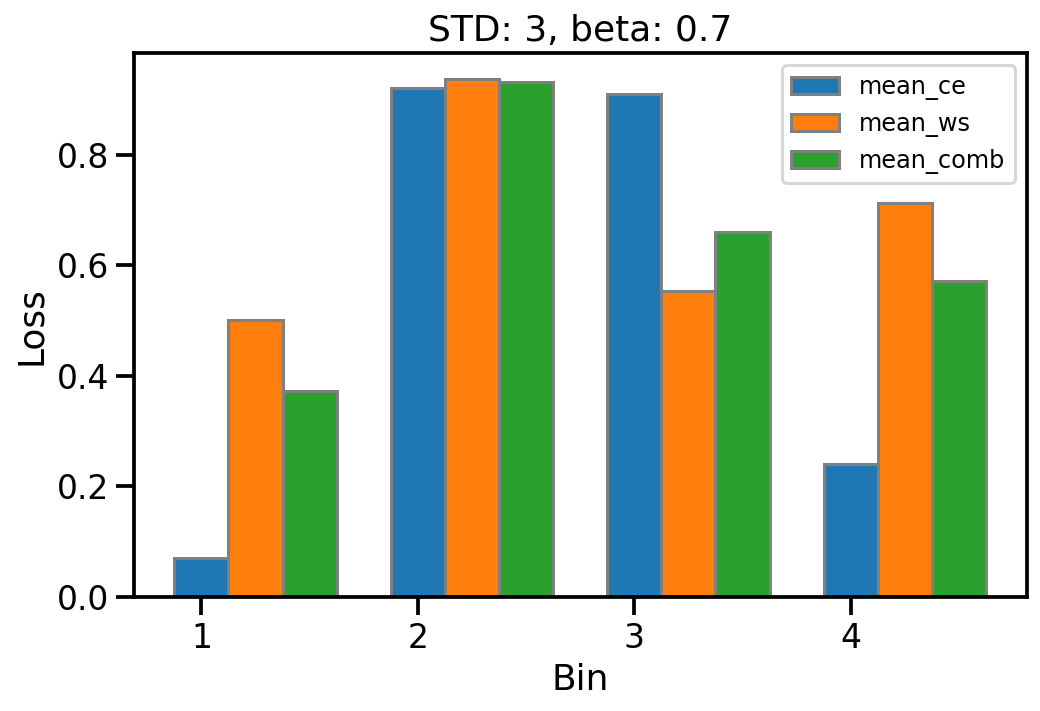

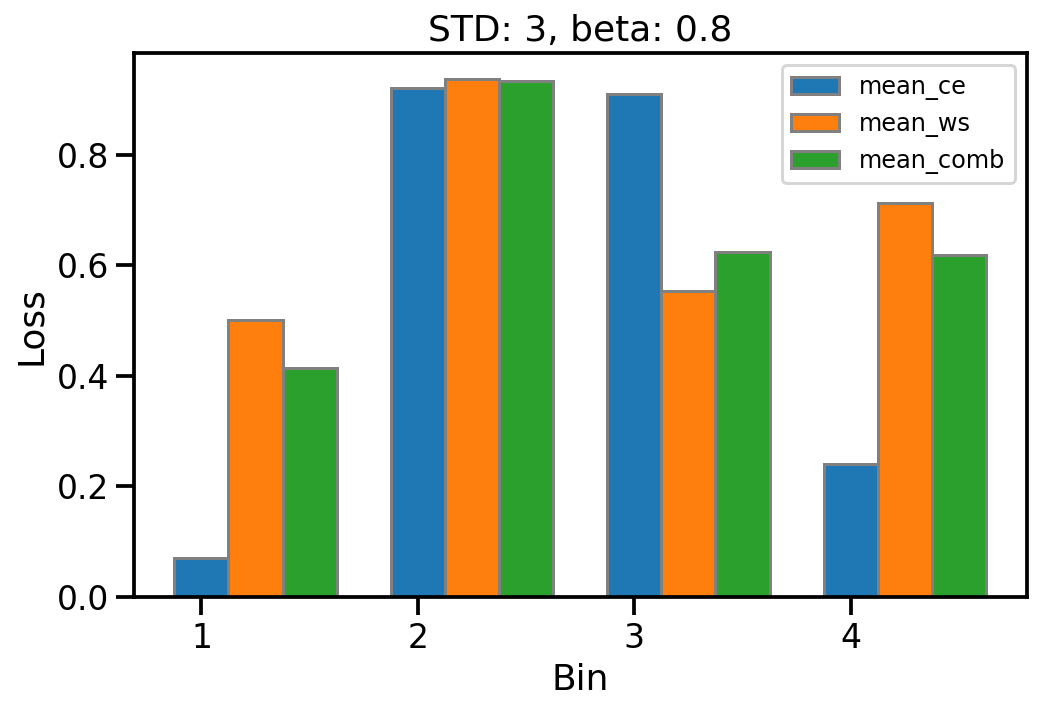

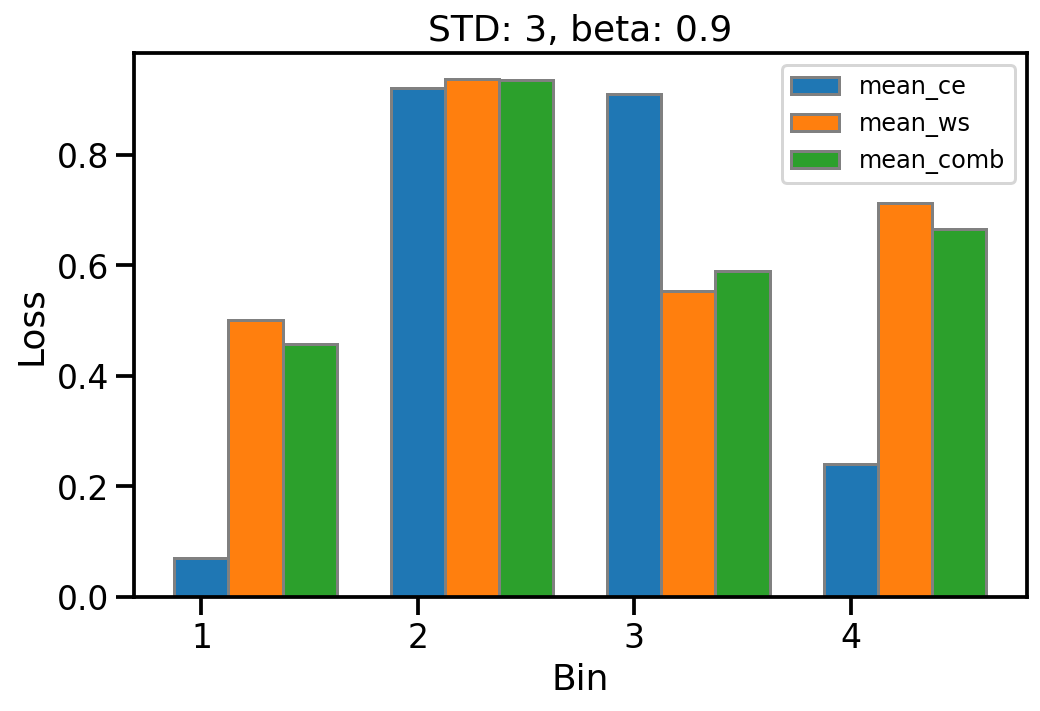

In [639]:
for beta in [0.6, 0.7, 0.8, 0.9]:
    alpha = 1 - beta
    D = create_D(BINS)
    D = kernel_distance(0, D, std=3)
    gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=alpha, beta=beta, normalize=True)
    plot_losses(full_loss_dict, title=f'STD: 3, beta: {beta}')

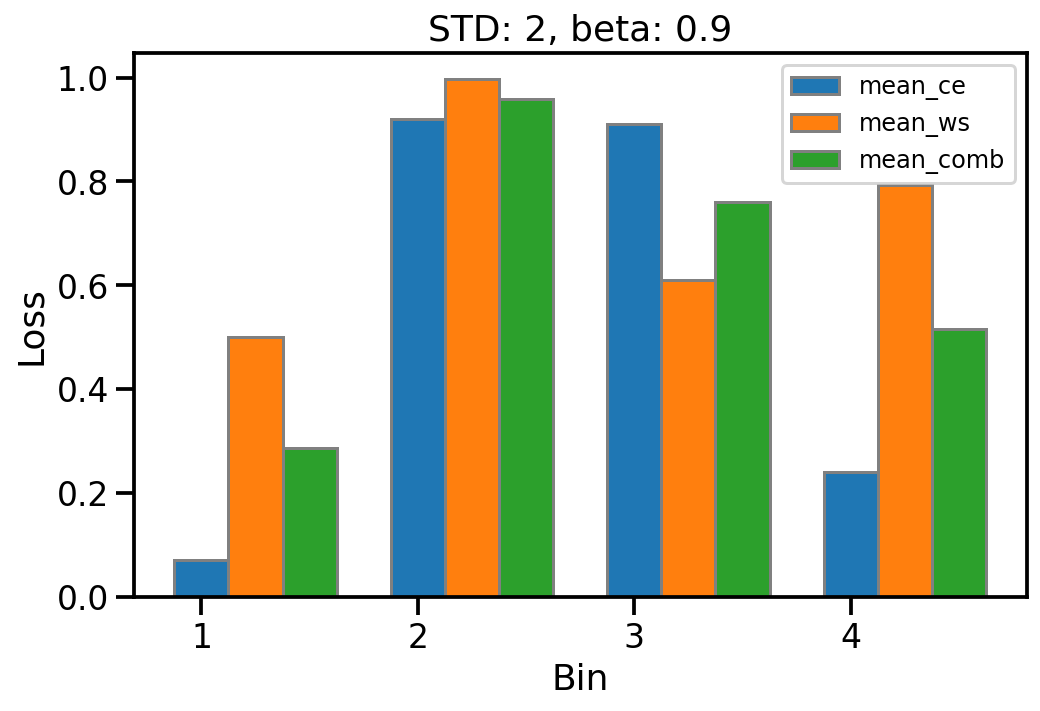

In [647]:
D = create_D(BINS)
D = kernel_distance(0, D, std=2)
gt_and_predicted_distributions, full_loss_dict = experiment_1(D, alpha=0.5, beta=0.5, normalize=True)
plot_losses(full_loss_dict, title=f'STD: 2, beta: {beta}')

In [640]:
from scipy.stats import entropy

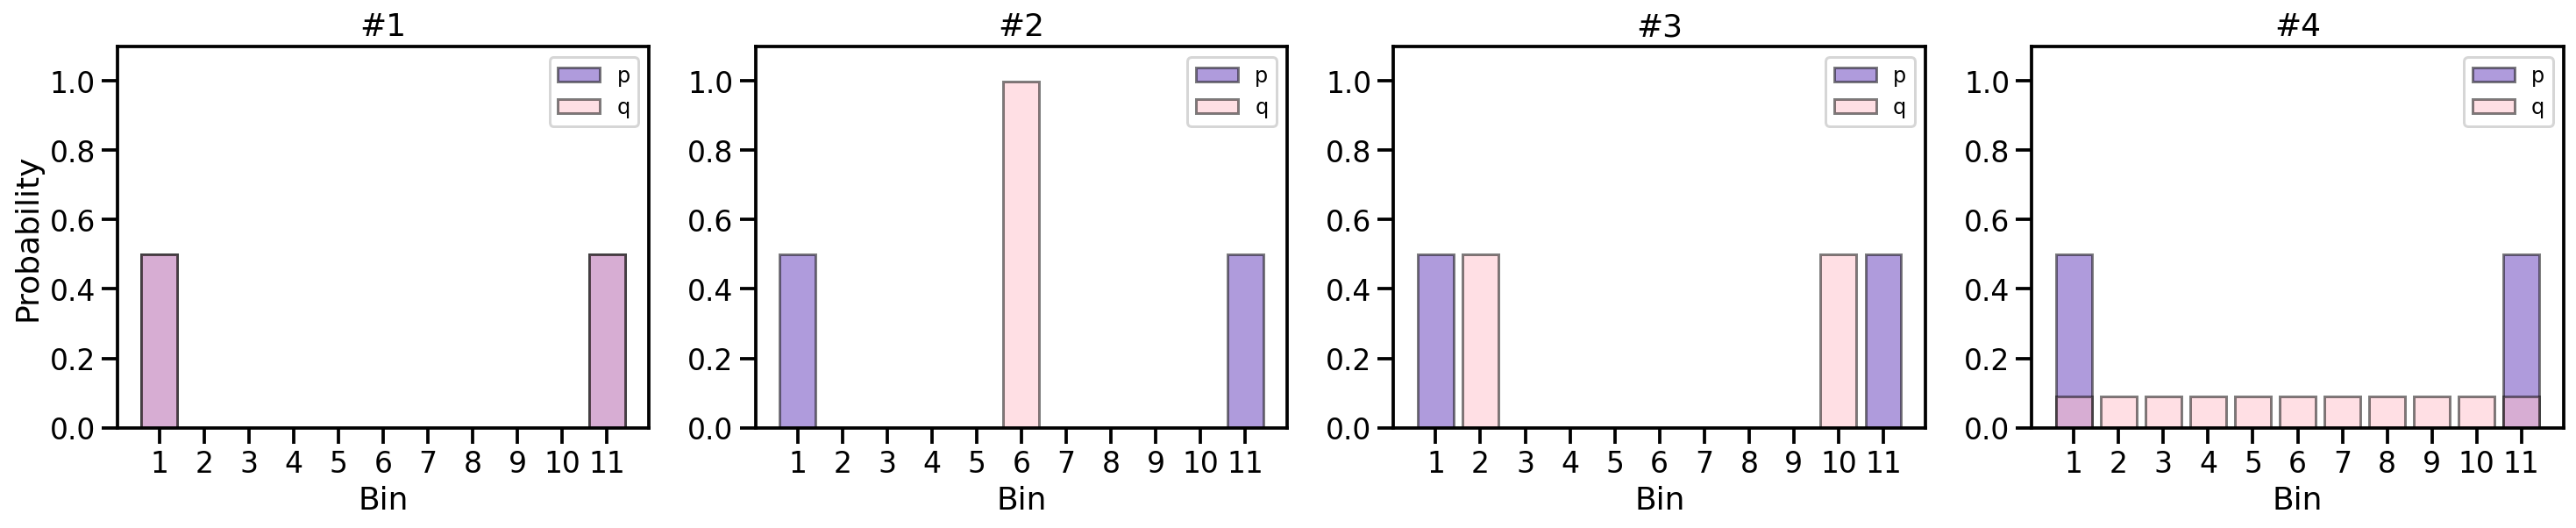

In [658]:
plot_distributions(gt_and_predicted_distributions)

In [668]:
[x['q'].probs for x in gt_and_predicted_distributions]

[array([4.99500000e-01, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01]),
 array([1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 9.99e-01,
        1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04, 1.00e-04]),
 array([1.11111111e-04, 4.99500000e-01, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 4.99500000e-01, 1.11111111e-04]),
 array([0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909, 0.09090909, 0.09090909, 0.09090909, 0.09090909,
        0.09090909])]

In [669]:
[x['p'].probs for x in gt_and_predicted_distributions]

[array([4.99500000e-01, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01]),
 array([4.99500000e-01, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01]),
 array([4.99500000e-01, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01]),
 array([4.99500000e-01, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 1.11111111e-04, 1.11111111e-04,
        1.11111111e-04, 1.11111111e-04, 4.99500000e-01])]

In [656]:
entropy_array = np.array([entropy(x['q'].probs) for x in gt_and_predicted_distributions])
entropy_array

array([0.70255851, 0.01020984, 0.70255851, 2.39789527])

In [657]:
ws_loss_array = np.array([x['mean_ws'] for x in full_loss_dict.values()])
ws_loss_array

array([0.50068855, 0.99752274, 0.61097397, 0.79331925])

In [662]:
0.3 * entropy_array + 0.7 * ws_loss_array

array([0.56124954, 0.70132887, 0.63844933, 1.27469206])

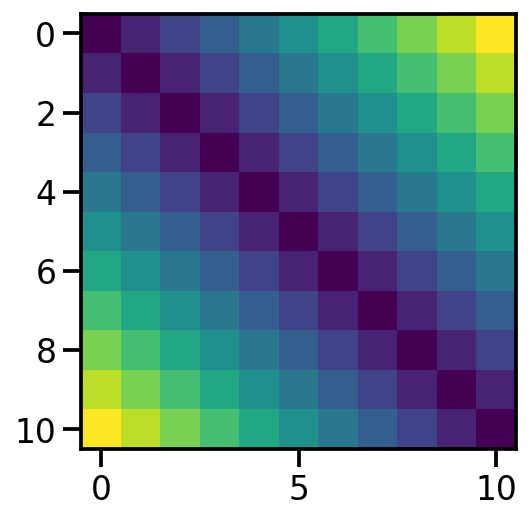

In [427]:
plt.imshow(D)

In [422]:
from scipy.special import expit

In [489]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

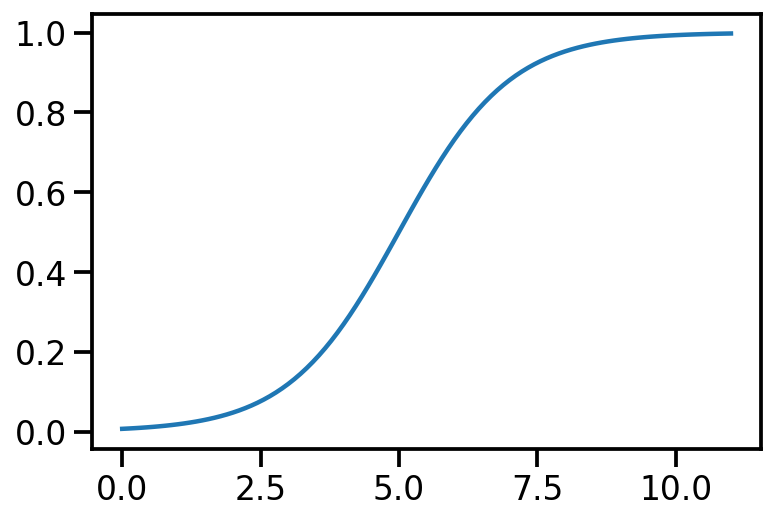

In [491]:
x_tmp = np.linspace(0, 11, 100)
plt.plot(x_tmp, expit(x_tmp - 5))

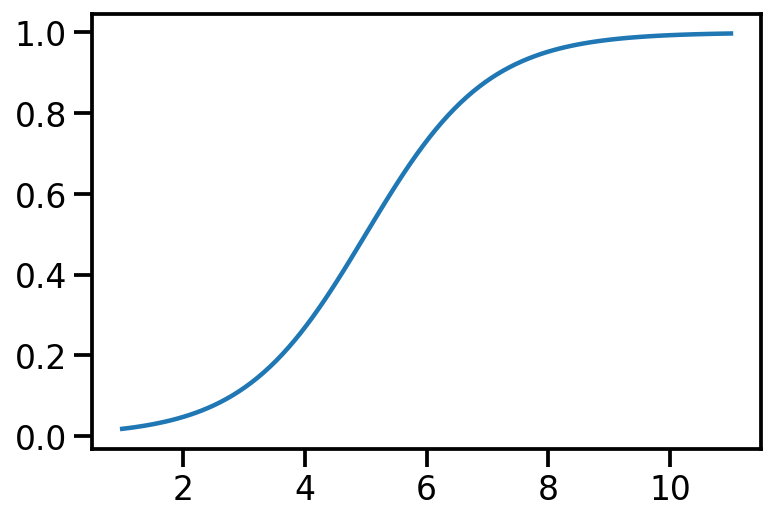

In [492]:
x_tmp = np.linspace(1, 11, 100)
plt.plot(x_tmp, sigmoid(x_tmp - 5))

In [499]:
def sigmoid(x, alpha=1):
    return 1 / (1 + np.exp(-alpha*x))

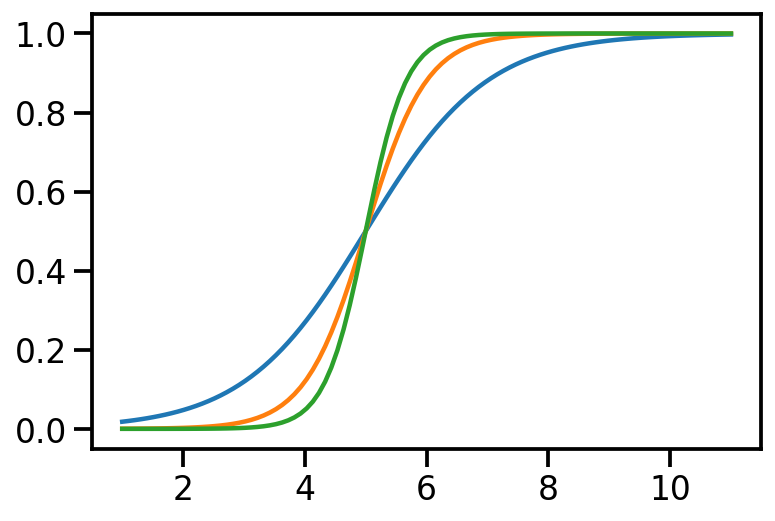

In [502]:
x_tmp = np.linspace(1, 11, 100)
plt.plot(x_tmp, sigmoid(x_tmp - 5, alpha=1))
plt.plot(x_tmp, sigmoid(x_tmp - 5, alpha=2))
plt.plot(x_tmp, sigmoid(x_tmp - 5, alpha=3))
plt.plot(x_tmp, sigmoid(x_tmp - 5, alpha=3))

In [337]:
ohe_samples

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

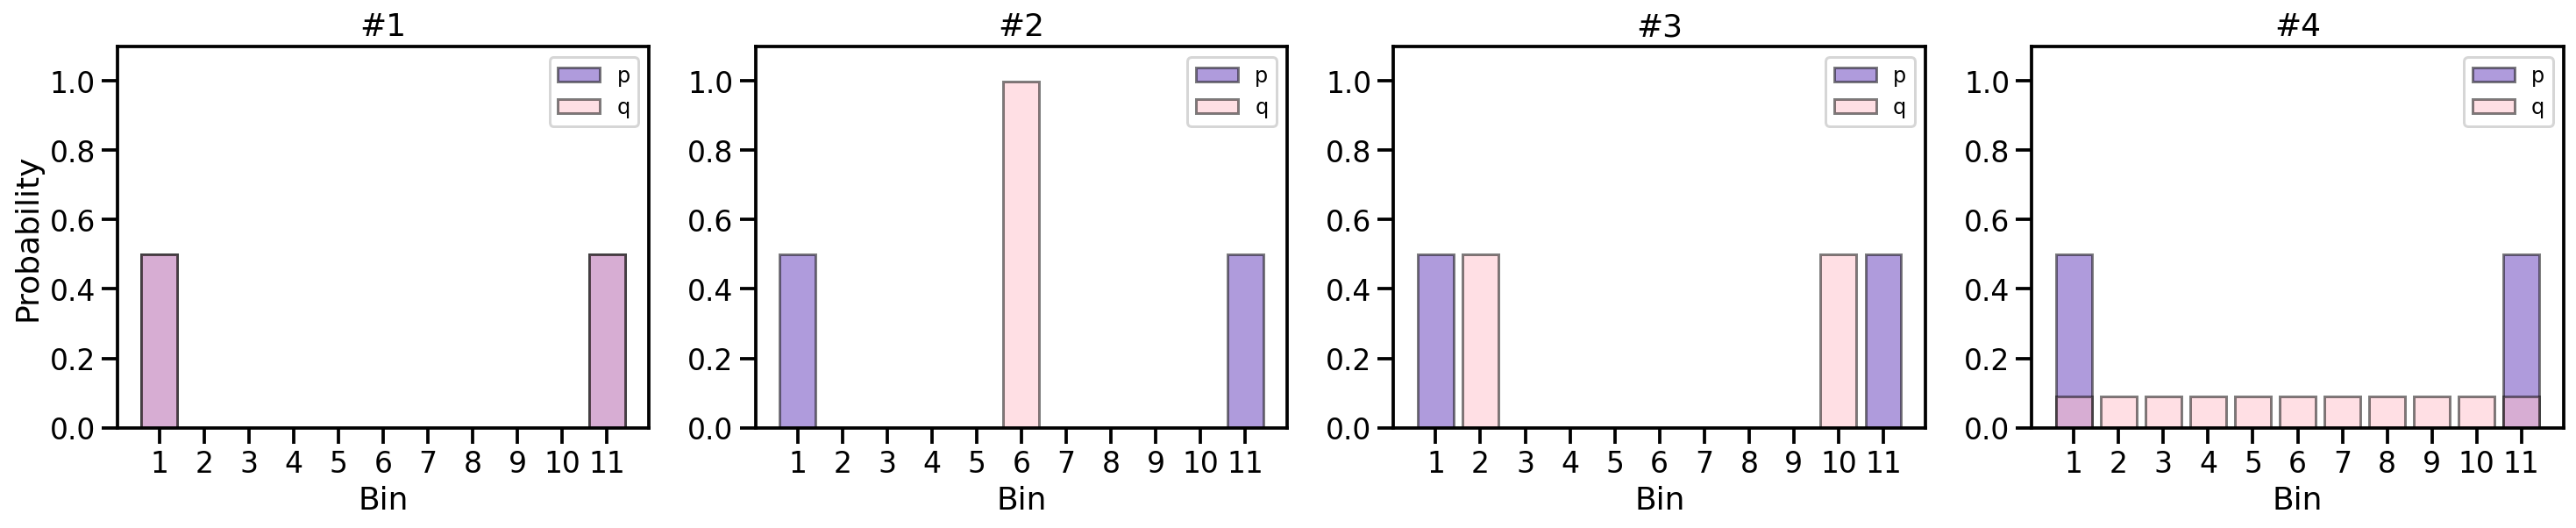

In [507]:
plot_distributions(gt_and_predicted_distributions)

In [509]:
# Say true bin is 1 and we predict uniform, as we do above. The CE loss is:
- np.log(0.1) # 0.1 b/c our predicted dist is uniform

2.3025850929940455

In [ ]:
# At its core, the entire crux is that you want to encode knowledge in your head that bins within 2-3 of eachother 
# are in some sense "close" and as you move past that they can be thought of as equally far away
# we just need to make this more robust

In [642]:
d1 = Distribution({1: 0.5, 11: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q1 = Distribution({2: 0.5, 10: 0.5}, eps=EXPERIMENT_PARAMS['eps'])
q2 = Distribution({i: 1 / 11 for i in np.arange(1, 12)}, eps=0)
q3 = Distribution({6: 1}, eps=EXPERIMENT_PARAMS['eps'])



In [513]:
print(cross_entropy(d1.probs, q1.probs))
print(cross_entropy(d1.probs, q2.probs))
print(cross_entropy(d1.probs, q2.probs))

9.103110782501597
2.3978952727983707


In [643]:
print(entropy(d1.probs))
print(entropy(q1.probs))
print(entropy(q2.probs))
print(entropy(q3.probs))

0.7025585130689538
0.7025585130689537
2.3978952727983707
0.010209840205226021


In [645]:
print(ws_loss(d1.probs, q1.probs, D))
print(ws_loss(d1.probs, q1.probs, D))
print(ws_loss(d1.probs, q2.probs, D))
print(ws_loss(d1.probs, q3.probs, D))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [524]:
import scipy
from scipy.stats import norm

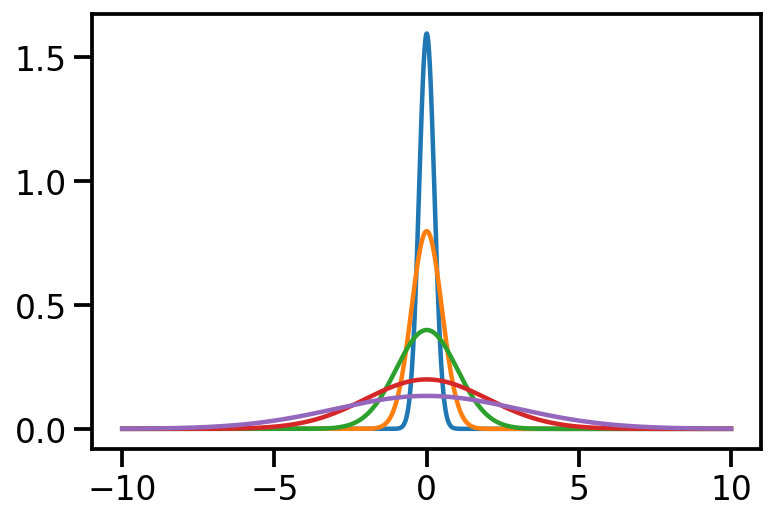

In [523]:
x_axis = np.arange(-10, 10, 0.01)

plt.plot(x_axis, norm.pdf(x_axis, 0, 0.25))
plt.plot(x_axis, norm.pdf(x_axis, 0, 0.5))    
plt.plot(x_axis, norm.pdf(x_axis, 0, 1))
plt.plot(x_axis, norm.pdf(x_axis, 0, 2))
plt.plot(x_axis, norm.pdf(x_axis, 0, 3))

In [527]:
def gaussian_kernel(x, y, std=1):
    dist = np.abs(x - y)
    K = np.exp(- (dist ** 2) / std ** 2)
    return K

In [528]:
gaussian_kernel(1, 1)

1.0

In [529]:
gaussian_kernel(1, 2)

0.36787944117144233

We can see below that the shapes are the same! The Gaussian kernel simply has a similarity of $1$ when it its two inputs are equidistant in euclidean space.

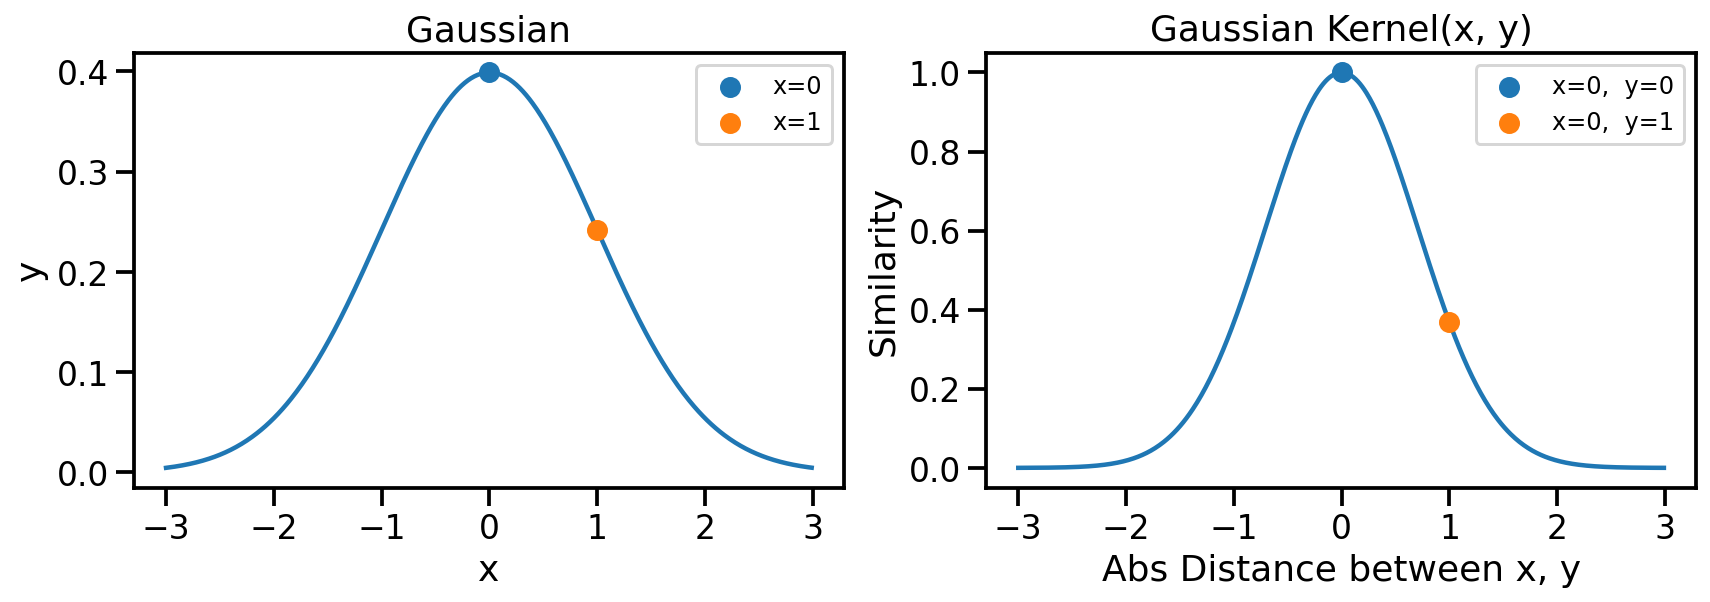

In [556]:
x_axis = np.arange(-3, 3, 0.01)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

axs[0].plot(x_axis, norm.pdf(x_axis, 0, 1))
axs[0].scatter([0], [norm.pdf([0], 0, 1)], label='x=0', zorder=5)
axs[0].scatter([1], [norm.pdf([1], 0, 1)], label='x=1', zorder=5)
axs[0].set_ylabel('y')
axs[0].set_xlabel('x')
axs[0].set_title('Gaussian')
axs[0].legend(fontsize=12)

axs[1].plot(x_axis, [res for res in gaussian_kernel(x_axis, 0)])

axs[1].scatter([0], [gaussian_kernel(0, 0)], label='x=0,  y=0', zorder=5)
axs[1].scatter([1], [gaussian_kernel(0, 1)], label='x=0,  y=1', zorder=5)
axs[1].set_ylabel('Similarity')
axs[1].set_xlabel('Abs Distance between x, y')
axs[1].set_title('Gaussian Kernel(x, y)')
axs[1].legend(fontsize=12)

In [564]:
def kernel_distance(x, y, std=1):
    x_x_similarity = gaussian_kernel(x, x, std=std)
    y_y_similarity = gaussian_kernel(y, y, std=std)
    x_y_similarity = gaussian_kernel(x, y, std=std)
    return x_x_similarity + y_y_similarity - (2 * x_y_similarity)

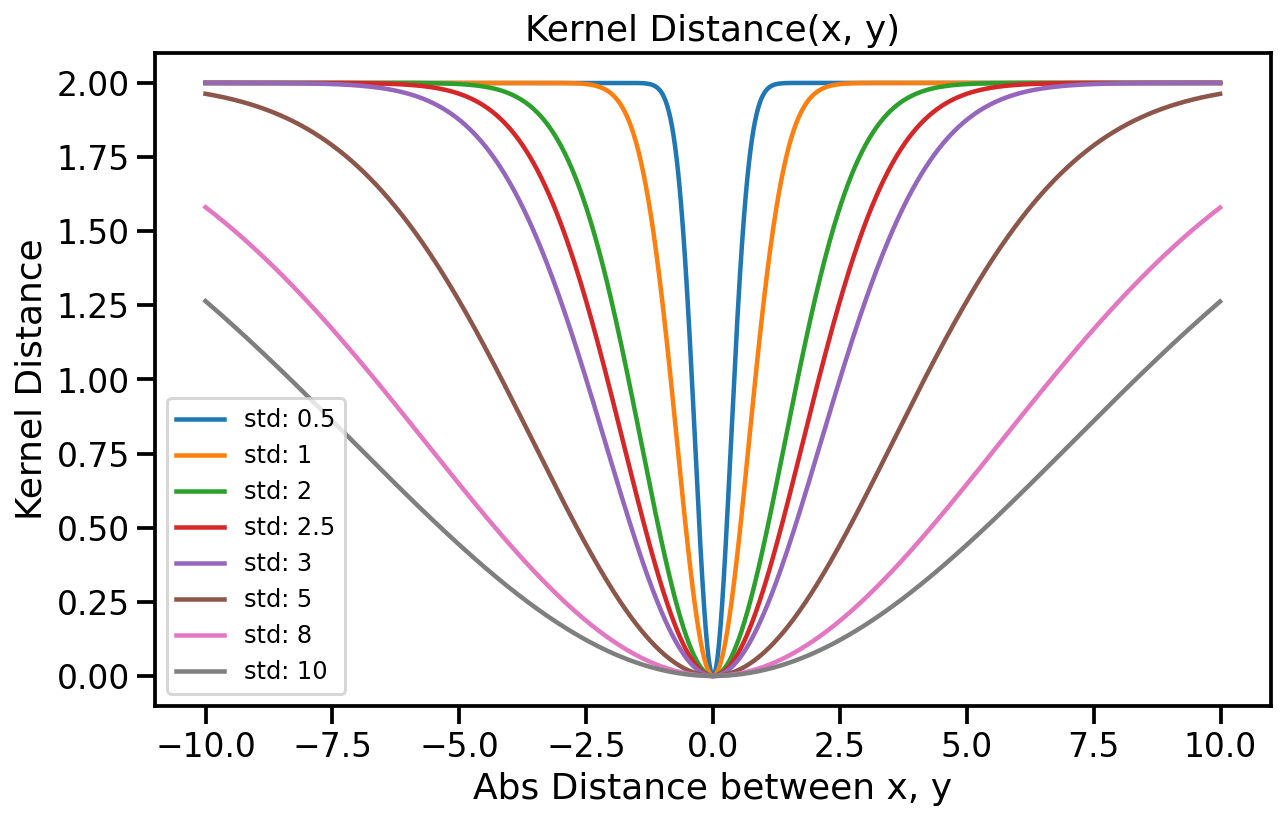

In [573]:
x_axis = np.arange(-10, 10, 0.01)

plt.figure(figsize=(10, 6))
for std in [0.5, 1, 2, 2.5, 3, 5, 8, 10]:
    plt.plot(x_axis, kernel_distance(x_axis, 0, std=std), label=f'std: {std}')

plt.ylabel('Kernel Distance')
plt.xlabel('Abs Distance between x, y')
plt.title('Kernel Distance(x, y)')
plt.legend(fontsize=12)
plt.show()

In [574]:
# Experiment to run: Try different distances and see how that impacts our different losses!
D = create_D(BINS)

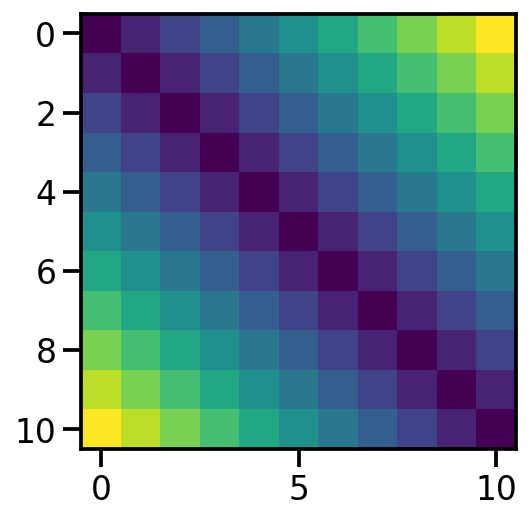

In [577]:
plt.imshow(D)

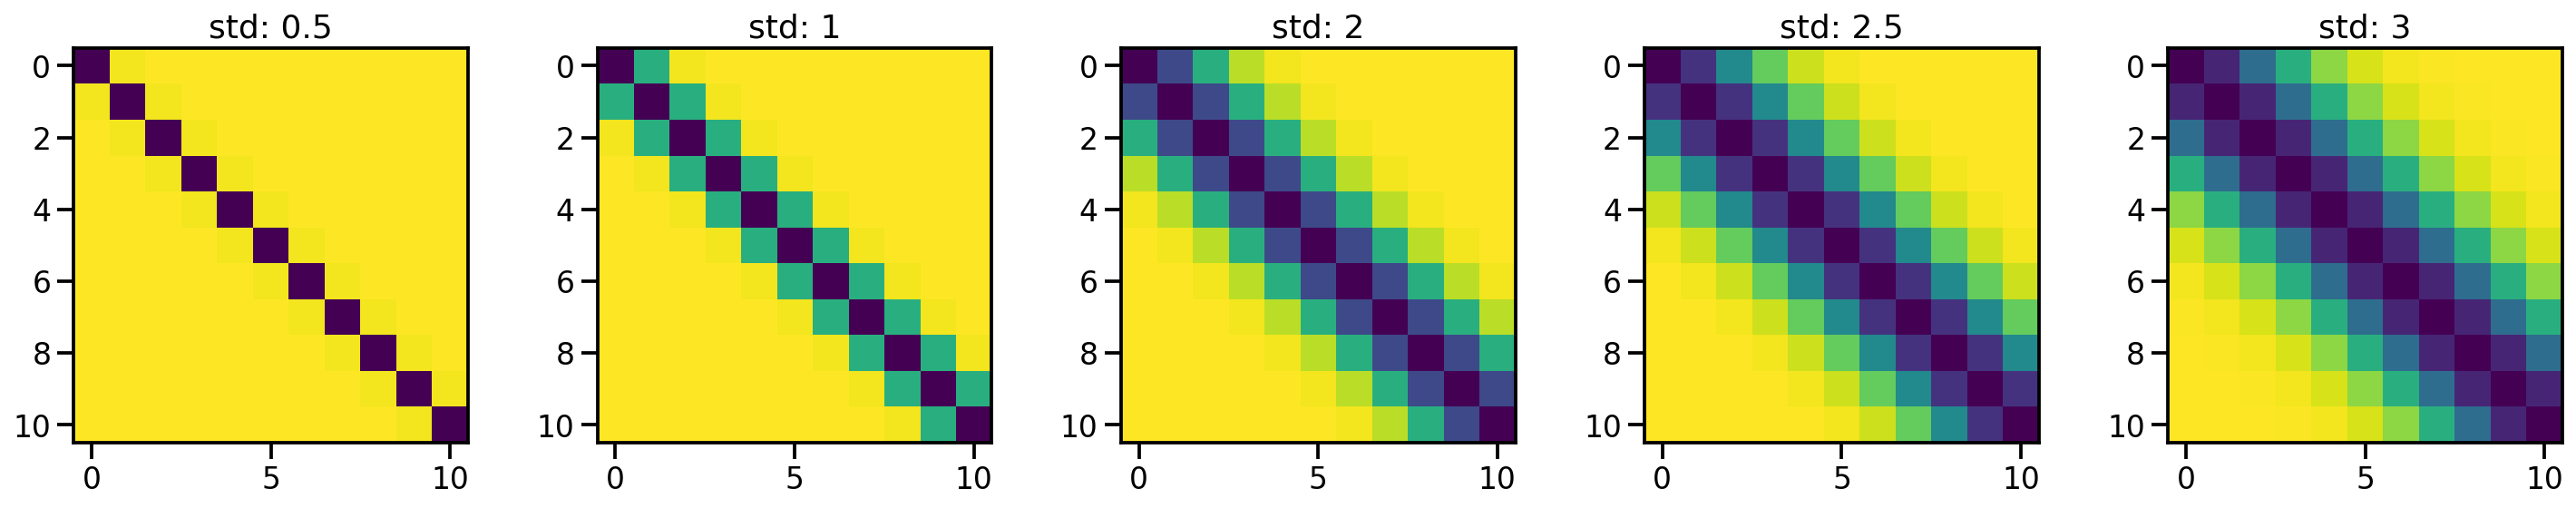

In [583]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 4))

stds = [0.5, 1, 2, 2.5, 3]
for ax, std in zip(axs, stds):
    ax.imshow(kernel_distance(0, D, std))
    ax.set_title(f'std: {std}')

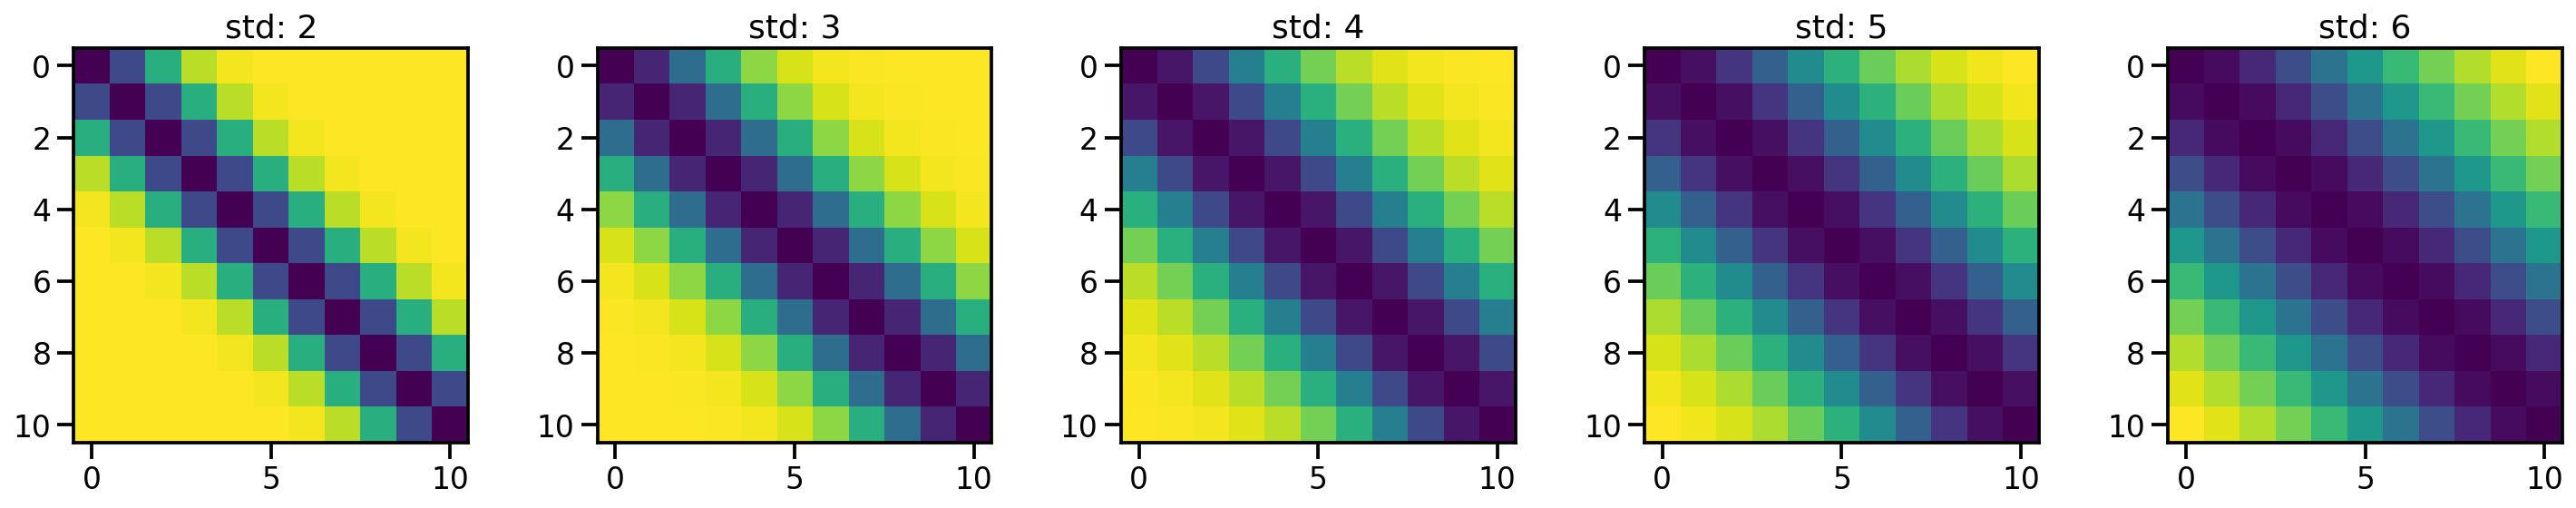

In [585]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(25, 4))

stds = [2, 3, 4, 5, 6]
for ax, std in zip(axs, stds):
    ax.imshow(kernel_distance(0, D, std))
    ax.set_title(f'std: {std}')

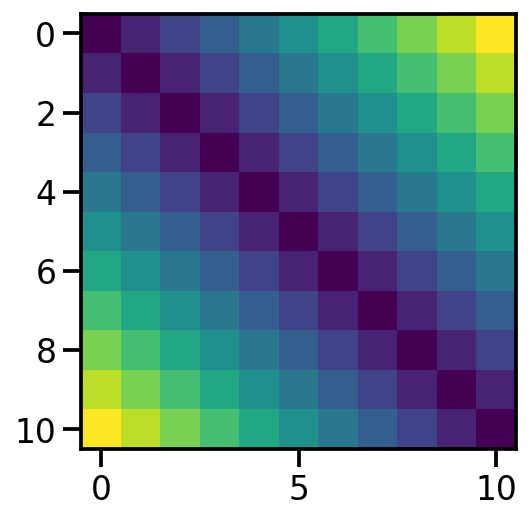

In [587]:
plt.imshow(D) # Anything is better than the original :) 

In [663]:
target_bin_edges: list[float] = [
    -10000.0,
    -5000.0,
    -1000.0,
    -500.0,
    -250.0,
    -100.0,
    -50.0,
    -25.0,
    -12.5,
    -5,
    -2,
    -1,
    -0.5,
    -0.25,
    0,
    0.25,
    0.5,
    1.0,
    2.0,
    5.0,
    12.5,
    25.0,
    50.0,
    100.0,
    250.0,
    500.0,
    1000.0,
    5000.0,
    10000.0,
]

In [664]:
bin_edges = target_bin_edges
bins = list(zip(bin_edges[:-1], bin_edges[1:]))

In [665]:
bins

[(-10000.0, -5000.0),
 (-5000.0, -1000.0),
 (-1000.0, -500.0),
 (-500.0, -250.0),
 (-250.0, -100.0),
 (-100.0, -50.0),
 (-50.0, -25.0),
 (-25.0, -12.5),
 (-12.5, -5),
 (-5, -2),
 (-2, -1),
 (-1, -0.5),
 (-0.5, -0.25),
 (-0.25, 0),
 (0, 0.25),
 (0.25, 0.5),
 (0.5, 1.0),
 (1.0, 2.0),
 (2.0, 5.0),
 (5.0, 12.5),
 (12.5, 25.0),
 (25.0, 50.0),
 (50.0, 100.0),
 (100.0, 250.0),
 (250.0, 500.0),
 (500.0, 1000.0),
 (1000.0, 5000.0),
 (5000.0, 10000.0)]

In [666]:
bin_mid = [i for i, x in enumerate(bins)]

In [667]:
bin_mid

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27]